In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here""s several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won""t be saved outside of the current session

In [3]:
pd.options.mode.chained_assignment = None

# BioAI Pfam

The aim of this notebook is to classify proteins on the Pfam dataset.

Author : Steven Le Moal

Last update : 26/10/2023

## Problem Statement
Classification of protein’s amino acid sequence to one of the protein family accession, based on Pfam dataset.
In other words, the task is: **given the amino acid sequence of the protein domain, predict which class (family_accession) it belongs to.**

* **1. Dataset Analysis :** Exploration of the statistics and potential issues of the dataset.
* **2. Method Explanation :** Explaination of the methods you used with the references cited.
* **3. Experiment Description :** set of experiments in order to prove the advantage (if they exist) of the proposed methods.
* **4. Result Analysis:** resume experiment results and analyze them.

Note : given the nature of the work, I choose to keep the functions in the notebook and not in a python script. I also choose not to set up a github with a peotry/pipenv.

## Data Overview
We have been provided with 5 features, they are as follows:

> **sequence**: These are usually the input features to the model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, and Z.

> **family_accession**: These are usually the labels for the model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

> **sequence_name**: Sequence name, in the form "uniprot_accession_id/start_index-end_index".

> **aligned_sequence**: Contains a single sequence from the multiple sequence alignment with the rest of the members of the family in seed, with gaps retained.

> **family_id**: One-word name for the family.

### Some imports

In [ ]:
! pip install tensorflow

In [ ]:
! pip install transformers

In [6]:
# Data analyse/visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

import numpy as np
import pandas as pd

import glob

from collections import Counter

plt.style.use("seaborn-whitegrid")

In [7]:
# Data preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [8]:
#Methode (model training)
from sklearn.utils import class_weight

from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers

import tensorflow_addons as tfa

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Embedding, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, MaxPooling1D

from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

In [9]:
dataset_path = "/kaggle/input/pfam-seed-random-split/random_split"

## Dataset Analysis

In this section, we will explore, visualize and try to understand the given dataset. 

The dataset is already split into 3 folders i.e., **train, dev, and test** using random split.

To begin, we will load the data.

In [10]:
def load_dataset(split: str) -> pd.DataFrame:
    data_chunks = glob.glob(f"{dataset_path}/{split}/*")
    read_data_chunks = [pd.read_csv(data_chunk) for data_chunk in data_chunks]
    read_df = pd.concat(read_data_chunks, ignore_index=True)
    read_df["split"] = split
    return read_df

In [11]:
basic_train_df = load_dataset("train")
basic_dev_df = load_dataset("dev")
basic_test_df = load_dataset("test")

In [12]:
basic_train_df.head()

family_id         sequence_name family_accession  \
0           YfcL     Q5E3V0_VIBF1/3-85       PF08891.11   
1  Somatomedin_B  F2UGX0_SALR5/258-297       PF01033.17   
2           Surp    K7J3U9_NASVI/11-59       PF01805.20   
3        DUF1230   E1ZG39_CHLVA/70-212       PF06799.11   
4         SRCR_2  F1NY88_CHICK/145-241        PF15494.6   

                                    aligned_sequence  \
0  IEFEEKMLELIDARIESASD.DELFAGGYLRGHISLSVANCEEQGI...   
1  TTCAVRG...C..........SDINL......NQNCQCD.PSC.YS...   
2  RNIIDKLAQFVA..R..NG....P........EFEQMT.KNK.......   
3  .AVPREQRPVNELQQLKDTPLLAW......ATLDL..PQYAQRL.....   
4  GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYN....VDT...   

                                            sequence  split  
0  IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...  train  
1           TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS  train  
2  RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT  train  
3  AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...  train  
4  GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...  train

### Dataset split analysis and preprocessing

We start by examining by examining the data in each split.

In [13]:
basic_all_df = pd.concat([basic_train_df, basic_dev_df, basic_test_df])

In [14]:
def get_proportion_split(basic_all_df: pd.DataFrame, basic_train_df: pd.DataFrame, basic_dev_df: pd.DataFrame, basic_test_df: pd.DataFrame) -> None:
    total_rows = len(basic_all_df)

    train_proportion = len(basic_train_df) / total_rows
    dev_proportion = len(basic_dev_df) / total_rows
    test_proportion = len(basic_test_df) / total_rows

    print(f"Train Proportion: {train_proportion:.2%}")
    print(f"Dev Proportion: {dev_proportion:.2%}")
    print(f"Test Proportion: {test_proportion:.2%}")
    

In [15]:
get_proportion_split(basic_all_df, basic_train_df, basic_dev_df, basic_test_df)

Train Proportion: 81.16%
Dev Proportion: 9.42%
Test Proportion: 9.42%


### Label distribution

The distribution of labels is important because there might by some imbalanced labels, which can affect our we define the machine learning problem.

In [16]:
num_classes = basic_all_df['family_accession'].nunique()
print(f'Number of classes (Families): {num_classes}')

Number of classes (Families): 17929


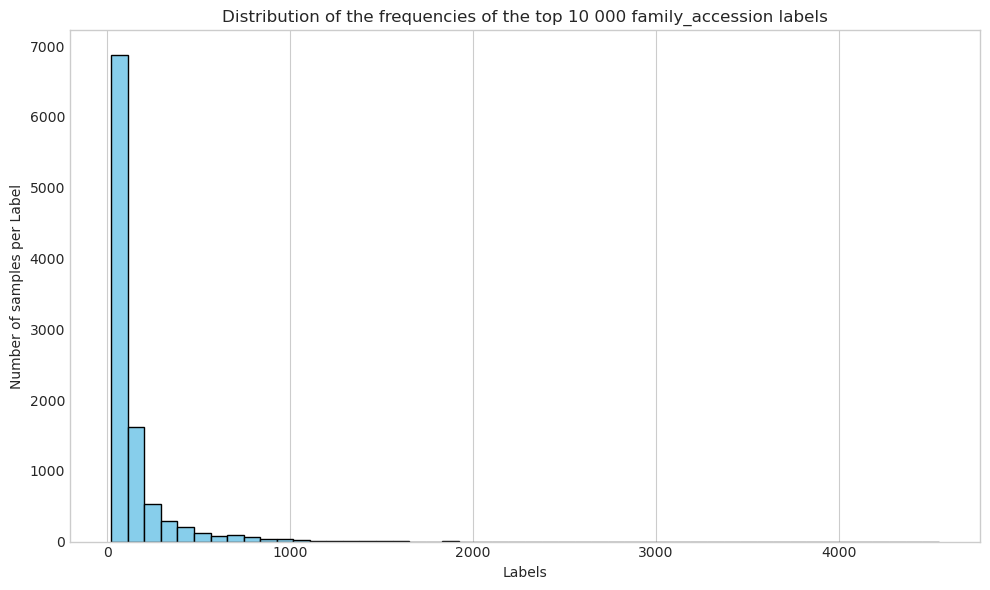

In [17]:
label_frequencies = basic_all_df['family_accession'].value_counts().head(10000).values

plt.figure(figsize=(10, 6))
plt.hist(label_frequencies, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of the frequencies of the top 10 000 family_accession labels')
plt.ylabel('Number of samples per Label')
plt.xlabel('Labels')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The **family size distributions** reveal that families with smaller sizes **(ranging from [0-500] samples per family) are quite common**, while those with larger sizes **(with [500+] samples per family) are less prevalent**. This indicates a **significant class imbalance**.
In the realm of machine learning, class imbalance is often problematic because families with limited samples are more challenging to identify compared to those with a higher representation in the data.

In [18]:
datasets = [
    basic_train_df['family_accession'], 
    basic_dev_df['family_accession'], 
    basic_test_df['family_accession']
]
names = ['Train', 'Dev', 'Test']

In [19]:
def plot_frequencies_per_set(datasets: pd.DataFrame, names: list, step:int =100, top_n:int =0) -> None:
    plt.figure(figsize=(20, 5))

    for i, (set_split, name) in enumerate(zip(datasets, names)):
        plt.subplot(1, 3, i + 1) 
        
        if top_n == 0:
            counts = set_split.value_counts()
        else:
            counts = set_split.value_counts().nlargest(top_n)
            
        selected_indices = np.arange(0, len(counts), step)
        top_counts = counts.iloc[selected_indices].values
        top_indices = counts.index[selected_indices]
        
        sns.barplot(x=top_indices, y=top_counts, alpha=0.8)

        plt.ylabel('Frequency')
        plt.xlabel('Classes')
        plt.title(f'Plot: {name}')
        plt.xticks([])
        
    plt.tight_layout()
    plt.show()


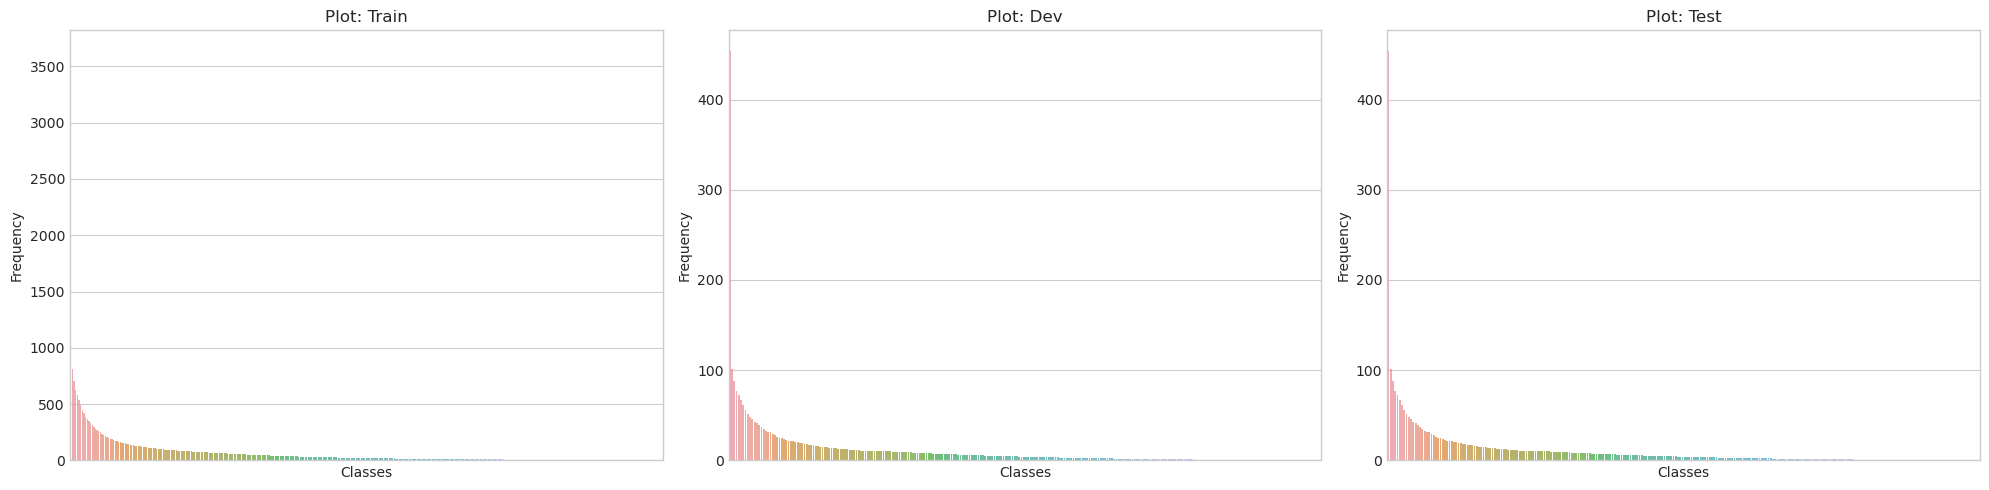

In [20]:
plot_frequencies_per_set(datasets, names, step=50)

From the above graphs, it's evident that the distribution of family sizes remains consistent across different sets, which is favorable. However, the class imbalance is still apparent.
Notably, the training set features a class with a count exceeding 3500, which is absent in both the development and test sets.

In [21]:
train_labels = set(np.unique(basic_train_df["family_accession"]))
dev_labels = set(np.unique(basic_dev_df["family_accession"]))
test_labels = set(np.unique(basic_test_df["family_accession"]))

In [22]:
print('Are the families of the dev set and the test set the same ?', dev_labels == test_labels)

Are the families of the dev set and the test set the same ? True


In [23]:
common_families = train_labels & dev_labels & test_labels # Take the intersection with the '&' operator
print('Number of common families in all sets : ', len(common_families))

Number of common families in all sets :  13071


In [24]:
pd.DataFrame({
    "split" : ["dev", "test"],
    "training set coverage": [
        len(train_labels & dev_labels) / len(dev_labels), 
        len(train_labels & test_labels) / len(test_labels)
    ]
})

split  training set coverage
0   dev                    1.0
1  test                    1.0

Training set covers all possible labels in dev and test. 
This is good. Now, let us consider the frequency of each **family_accession** label.

The displayed results highlight a **pronounced imbalance within our dataset**.
Additionally, the sheer volume of labels is overwhelming. If we were to assign a probability to every label, the output's dimension would be num_labels. Such a vast number of parameters not only runs the risk of overfitting but also demands immense computational resources. What's more, with this abundance of labels, the widely used **softmax activation** function may **face challenges** related to time efficiency and numerical stability. Considering the limitations of this notebook setup and our time constraints, we'll focus our **classification model on the top 128 classes**.
**Narrowing down the classes** accomplishes two things: it sidesteps the issue of an excessive number of classes and mitigates the class imbalance. Now, e**very family in the set will have a more significant representation**.

Potential Future Direction:

> The approach we've settled on may not be perfect if our goal is to craft a model adept at identifying every protein domain family. Absent computational barriers, strategies to counteract class imbalance (while preserving as much data as possible) might include techniques like over-sampling or, even better, ensemble learning.
> In a more expansive setting, my approach would be twofold. First, I'd develop a broad-spectrum classification model to predict labels signifying "clusters of labels". Following that, I'd design specialized, more detailed classification models for each "label cluster".

**Distribution of the frequencies of the top 128 families per set**

In [25]:
num_labels = 128

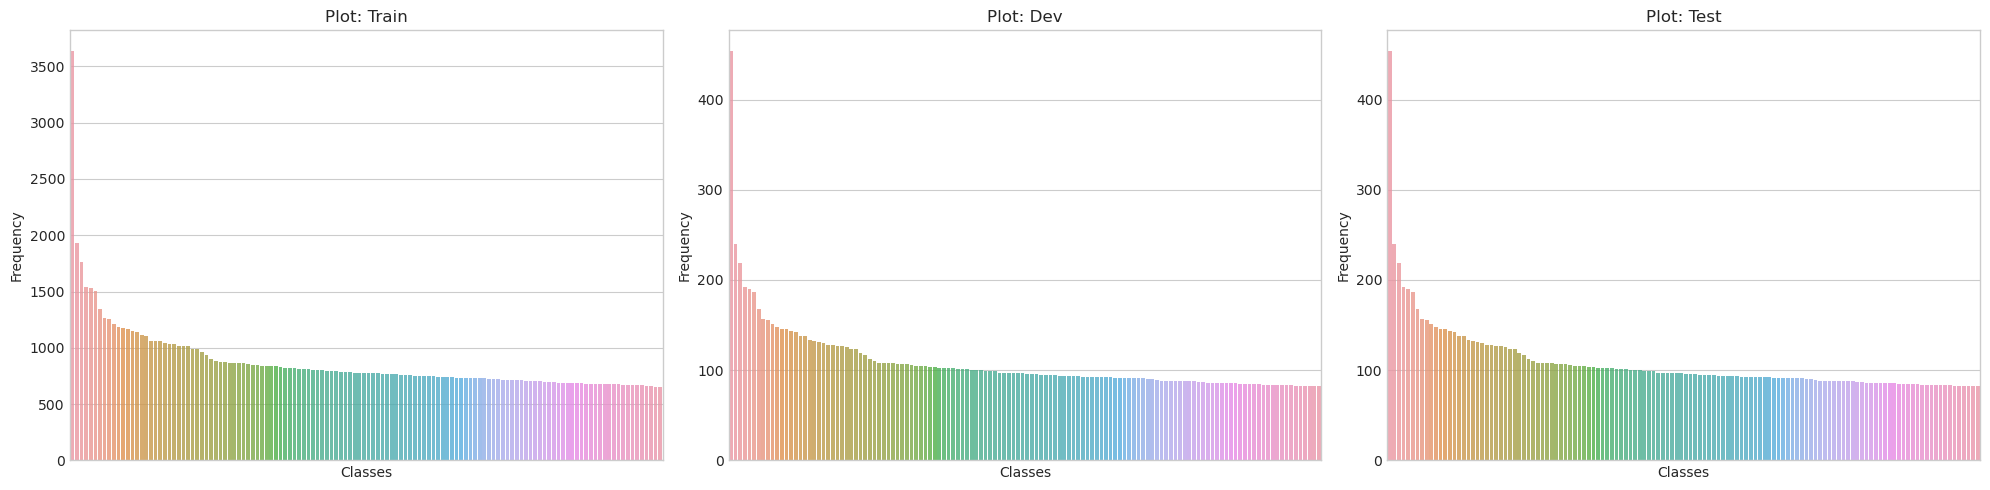

In [26]:
plot_frequencies_per_set(datasets, names, step=1, top_n=num_labels)

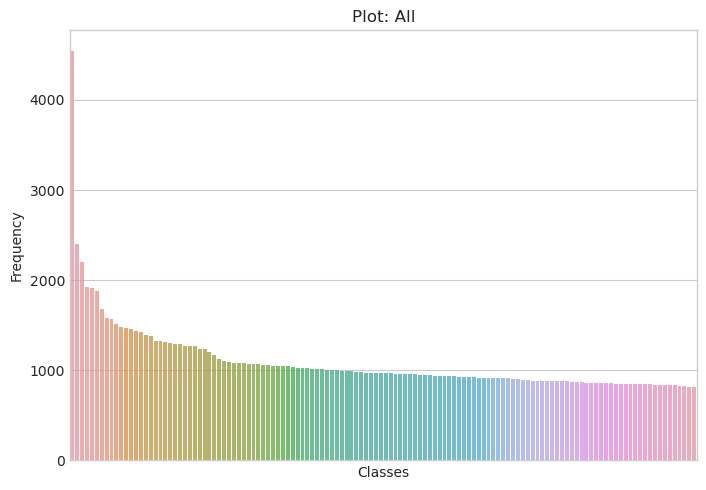

In [27]:
plot_frequencies_per_set([basic_all_df['family_accession']], ['All'], step=1, top_n=num_labels)

The visual representation from the previous plot suggests that, for the top 128 labels, the distribution of sequences per label is relatively even. However, a slight imbalance might be observed among the top 5 most frequently occurring labels.
Let's now move forward and refine the dataset to include only the top 128 most prevalent labels.

In [28]:
basic_counts = basic_all_df.value_counts("family_accession")

top_labels_df = pd.DataFrame({
    "label":  basic_counts.iloc[:num_labels].index.to_list(),
    "count" : basic_counts.iloc[:num_labels].to_list()
})

In [29]:
most_common_labels = top_labels_df.label.to_list()

In [30]:
def select_most_frequent_labels(dataset):
    mask = dataset.family_accession.isin(most_common_labels)
    return dataset.loc[mask, :]

In [31]:
train_df = select_most_frequent_labels(basic_train_df)
dev_df = select_most_frequent_labels(basic_dev_df)
test_df = select_most_frequent_labels(basic_test_df)
all_df = pd.concat([train_df, dev_df, test_df])
train_df.head()

family_id         sequence_name family_accession  \
5            WD40    SRW1_SCHPO/406-447       PF00400.32   
10           YceI   Q8XVV9_RALSO/29-186       PF04264.13   
24           UbiA   X5A117_9BACL/24-271       PF01040.18   
52  DnaJ_CXXCXGXG  M1E599_9FIRM/142-205       PF00684.19   
56           WD40  Q93339_CAEEL/328-366       PF00400.32   

                                     aligned_sequence  \
5   EKPLYS..F....H.....NH......IA...........AV...K...   
10  .QVDA..AKSSVT..............A.....................   
24  AFMGAL.LG.......SMVMSGSLP..SW............RDIGW...   
52  CEKCE.GKG.....S..V.S..GRK.....V....V.CKVCHGTG....   
56  KKELLY..Q....E.....GH....SKS.............V...A...   

                                             sequence  split  
5          EKPLYSFHNHIAAVKAITWSPHQRGILASGGGTADRTIKLWN  train  
10  QVDAAKSSVTATGKQLGVPMDIKFGKFDAAVSYNPANLAASTAKVD...  train  
24  AFMGALLGSMVMSGSLPSWRDIGWIIIAMFGARSAAMGLNRLIDRV...  train  
52  CEKCEGKGSVSGRKVVCKVCHGTGQVTSSRRTILGNVYQTYSCPEC...  train  
56            KKELLYQEGHSKSVADVAFHPDGSVALTGGHDCYGRVWD  train

Now, let us reconsider train, dev and test split ratio.

In [32]:
get_proportion_split(all_df, train_df, dev_df, test_df)

Train Proportion: 80.08%
Dev Proportion: 9.96%
Test Proportion: 9.96%


It's encouraging to see that the results remain consistent even after the pre-processing. Given this consistency, it's appropriate to proceed with the current split.

### Sequence length distribution

We are dealing with protein sequences which are variable sequence lengths. 

In [33]:
def compute_seq_lens(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "split": df["split"].to_list(),
        "seq_len" : df["sequence"].apply(len).to_list()
    })

In [34]:
seq_lens_grouped_by_split = pd.concat([
    compute_seq_lens(train_df),
    compute_seq_lens(dev_df),
    compute_seq_lens(test_df)
])

quantile_99 = seq_lens_grouped_by_split["seq_len"].quantile(0.99)

In [35]:
def plot_sequence_distribution(data_splits: list, names:list, quantile_percent:float=0.99, kde:bool=True) -> None:
    show_quantile = True
    if quantile_percent <= 0 or quantile_percent >= 1:
        show_quantile = False
        
    num_fig = len(data_splits)
    fig, axes = plt.subplots(1, num_fig, figsize=(18, 6))

    if num_fig == 1:
        axes = [axes]

    for ax, data, name in zip(axes, data_splits, names):
        sns.histplot(data=data, x="seq_len", ax=ax, hue="split", kde=kde, bins=100, alpha=0.6)
        
        if num_fig ==1:
            plt.xlim((0, seq_lens_grouped_by_split["seq_len"].max()))
            plt.ylim((0, plt.gca().get_ylim()[1]))
        

        if show_quantile:
            quantile = data["seq_len"].quantile(quantile_percent)
            ax.axvline(quantile, color='red', linestyle='--')

            ax.fill_between([quantile, data["seq_len"].max()], 
                            y1=0, y2=ax.get_ylim()[1], color='none', hatch='//', edgecolor='gray', alpha=0.5)

            ax.text(quantile * 0.6, ax.get_ylim()[1] * 0.8, f'{str(quantile_percent)[-2:]}% of the sequence', rotation=0, fontsize=10, ha='center')

        ax.set_title(f"Sequence length distribution ({name})")

    plt.tight_layout()
    plt.show()

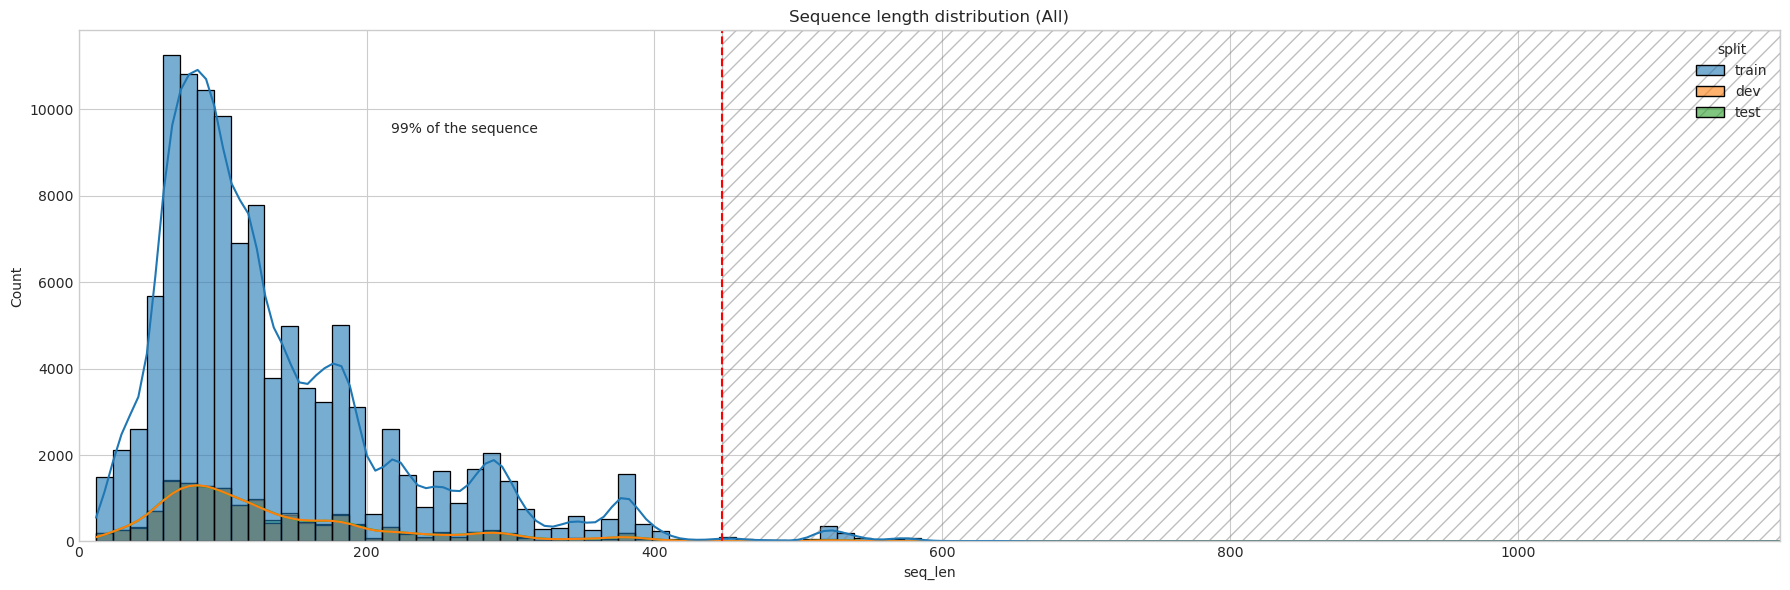

In [67]:
plot_sequence_distribution([seq_lens_grouped_by_split], ['All'], quantile_percent=0.99)

Most of sequences have length in range 50-150. To reduce computational complexity, we will **truncate and pad sequences to length of 300**.

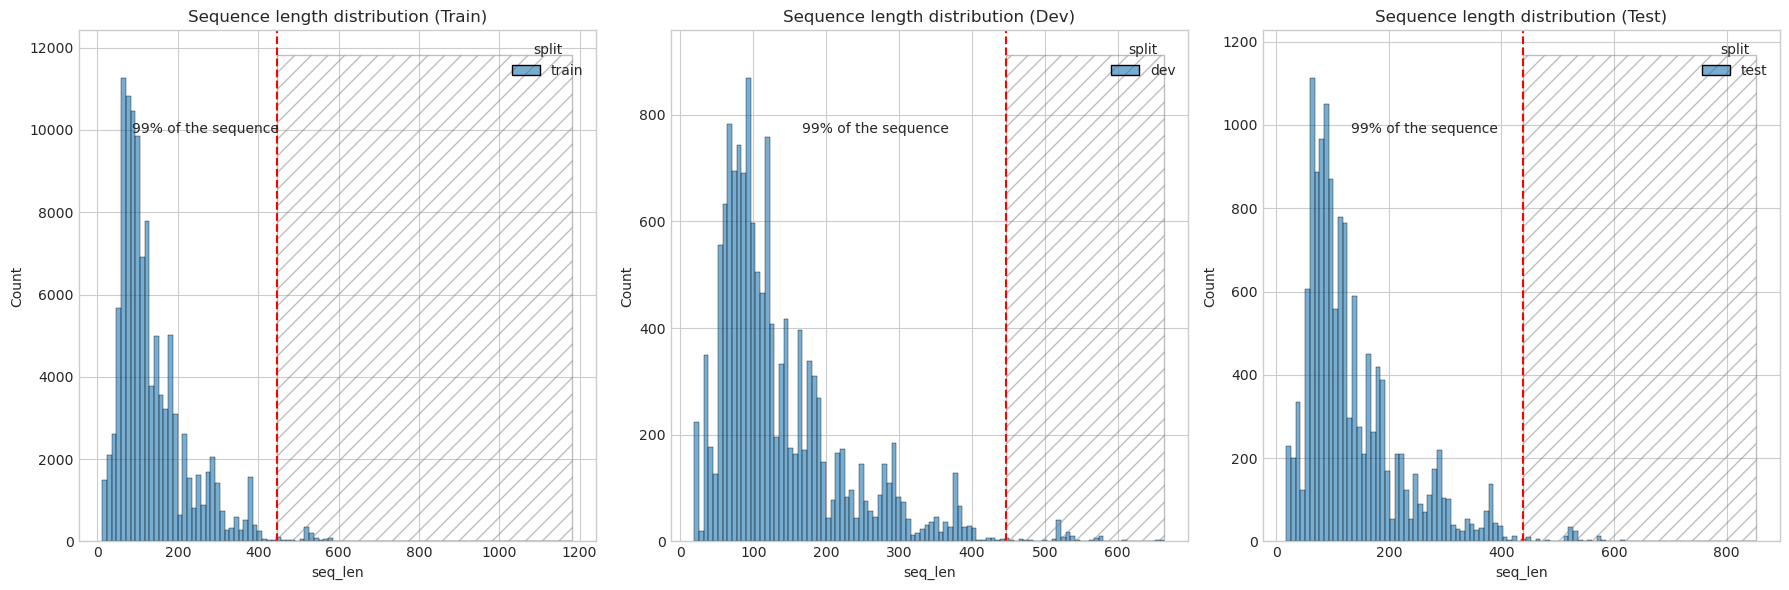

In [37]:
seq_lens_train = compute_seq_lens(train_df)
seq_lens_dev = compute_seq_lens(dev_df)
seq_lens_test = compute_seq_lens(test_df)

data_splits = [seq_lens_train, seq_lens_dev, seq_lens_test]

plot_sequence_distribution(data_splits, ['Train', 'Dev', 'Test'], quantile_percent=0.99, kde=False)

### Amino acids distribution

Let us examine the property of protein sequence dataset : the distribution of amino acids

In [38]:
def compute_aminoacids_freq(df: pd.DataFrame) -> pd.DataFrame:
    freq_per_acid = Counter("".join(df["sequence"]))
    freq_df = pd.DataFrame({
        "acid": list(freq_per_acid.keys()), 
        "freq": list(freq_per_acid.values())
    })
    return freq_df.sort_values("freq", ascending=False).reset_index()[["acid", "freq"]]

In [39]:
def plot_amino_acids_distribution(amino_acids_freq_dfs:list, titles:list =["in dataset"], scale:float =1e6, scale_name:str ='M: million') -> None:
    n_plots = len(amino_acids_freq_dfs)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
    
    if n_plots == 1: 
        axes = [axes]
    
    for ax, amino_acids_freq_df, title in zip(axes, amino_acids_freq_dfs, titles):
        
        sns.barplot(x="acid", y="freq", data=amino_acids_freq_df, ax=ax)
        ax.set_title(f'Amino acids frequency distribution {title}')
        
        labels = [f'{val/scale:.2f}{scale_name[0]}' if val > 0 else '0' for val in ax.get_yticks()]
        
        ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(labels)
        
        ax.annotate(scale_name, xy=(0.95, 1), xycoords='axes fraction', fontsize=9,
                    xytext=(5, -15), textcoords='offset points',
                    ha='right', va='bottom')
        
    plt.tight_layout()
    plt.show()

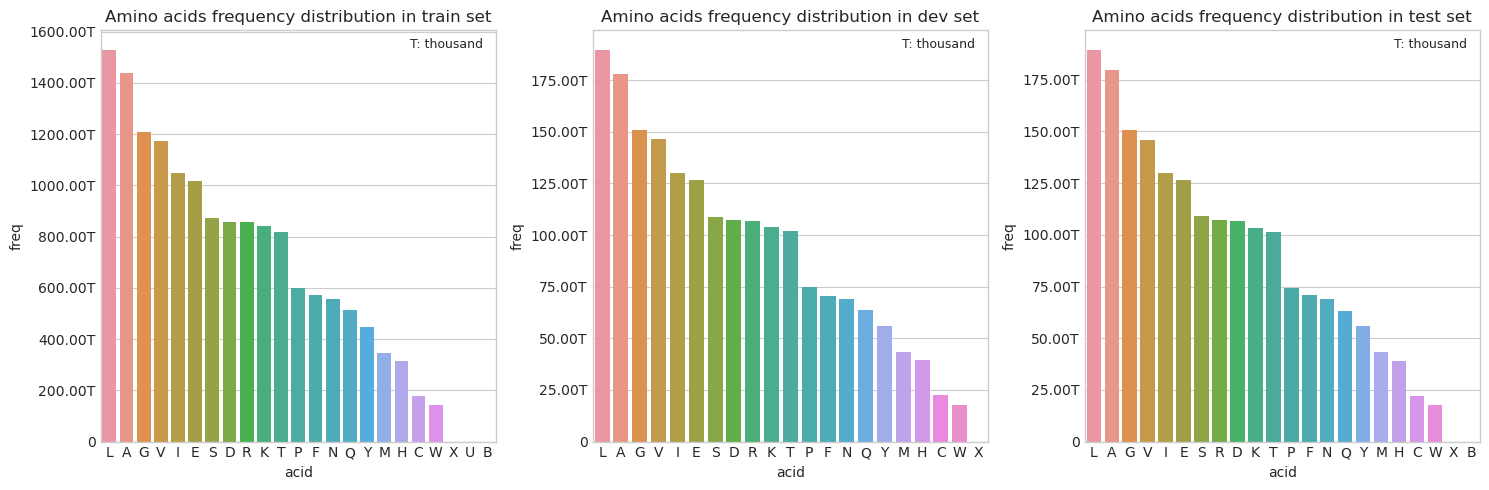

In [40]:
plot_amino_acids_distribution(
    [compute_aminoacids_freq(train_df), compute_aminoacids_freq(dev_df), compute_aminoacids_freq(test_df)],
    ["in train set", "in dev set", "in test set"],
    scale=1e3,
    scale_name='T: thousand'
)

In [41]:
amino_acids_freq_df_raw = compute_aminoacids_freq(basic_all_df)
amino_acids_freq_df = compute_aminoacids_freq(all_df)

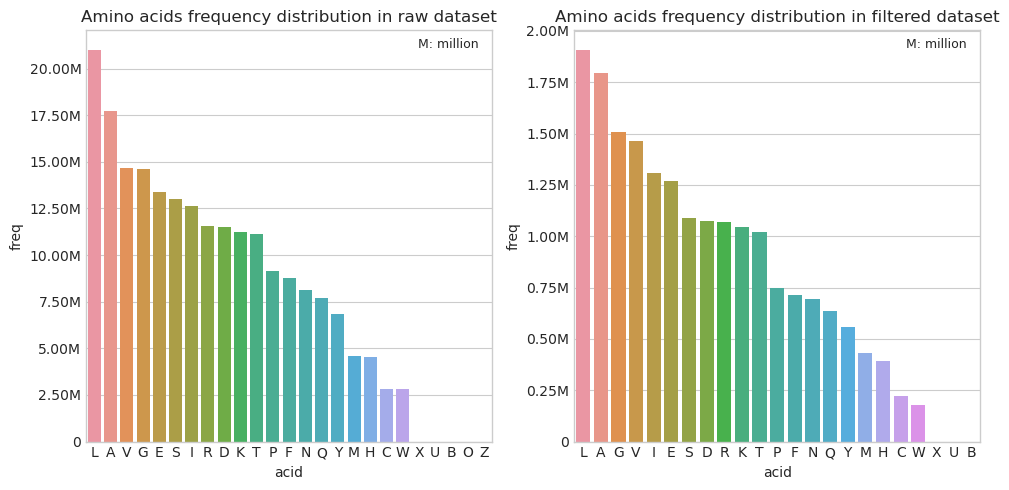

In [42]:
plot_amino_acids_distribution([amino_acids_freq_df_raw, amino_acids_freq_df], titles=["in raw dataset", "in filtered dataset"])

The observations above highlight an uneven distribution of amino acid frequencies. It's noteworthy that **X, U, B** are extremely infrequent, while **O, Z** are completely absent in our refined dataset.

Given the unreliability of predictions stemming from such rare occurrences, the most prudent approach would be to **omit (or disregard) them**.

In [43]:
frequent_acids = amino_acids_freq_df.acid.to_list()[:-3]

In [44]:
def build_acid_lookup_table(acids: list) -> dict:
    acid_index = {}
    for ix, acid in enumerate(acids):
        acid_index[acid] = ix + 1
    return acid_index

In [45]:
acid_index = build_acid_lookup_table(frequent_acids)
acid_index

{'L': 1,
 'A': 2,
 'G': 3,
 'V': 4,
 'I': 5,
 'E': 6,
 'S': 7,
 'D': 8,
 'R': 9,
 'K': 10,
 'T': 11,
 'P': 12,
 'F': 13,
 'N': 14,
 'Q': 15,
 'Y': 16,
 'M': 17,
 'H': 18,
 'C': 19,
 'W': 20}

In [46]:
def integer_encode(df: pd.DataFrame) -> list:
    encoded = []
    not_frequent_acid_index = 0
    for seq in df["sequence"]:
        encoded.append(
            np.array([acid_index.get(acid, not_frequent_acid_index) for acid in seq])
        )

    return encoded

Now perform integer encoding.

In [47]:
train_seqs_encoded = integer_encode(train_df)
dev_seqs_encoded = integer_encode(dev_df)
test_seqs_encoded = integer_encode(test_df)

Now perform padding.

> Padding means that we will add a fixed size to all sequence by adding -1 or by remove element until reaching the deasire size.. This is used often in NLP task. Even though we could create a model that can handle variable sequence size, we will focus on creating "simple" models that work with fixed size sequence.


In [48]:
max_seq_len = 300

In [49]:
x_train = pad_sequences(
    train_seqs_encoded, 
    maxlen=max_seq_len, 
    padding="post", 
    truncating="post"
)
x_dev = pad_sequences(
    dev_seqs_encoded, 
    maxlen=max_seq_len, 
    padding="post",
    truncating="post"
)
x_test = pad_sequences(
    test_seqs_encoded, 
    maxlen=max_seq_len, 
    padding="post", 
    truncating="post"
)
print(x_train.shape, x_dev.shape, x_test.shape)

(112061, 300) (13936, 300) (13936, 300)


For the model **ProtBERT**: we need to keep the character (str)

In [50]:
def protbert_encode(df: pd.DataFrame) -> list:
    encoded = []
    for seq in df["sequence"]:
        encoded.append(
            str(seq)
        )

    return encoded

In [51]:
x_train_protbert = protbert_encode(train_df)
x_dev_protbert = protbert_encode(dev_df)
x_test_protbert = protbert_encode(test_df)

Now let us **one-hot encode corresponding sequences**

We will try to see if one-hot encoding can help the models better understand the input than using the classical acids amino encoding (1 to 20)

In [52]:
#one-hot encoding
x_train_one_hot = to_categorical(x_train)
x_dev_one_hot = to_categorical(x_dev)
x_test_one_hot = to_categorical(x_test)

print(x_train_one_hot.shape, x_dev_one_hot.shape, x_test_one_hot.shape)

(112061, 300, 21) (13936, 300, 21) (13936, 300, 21)


Now let us **one-hot encode corresponding labels.**

In [53]:
#Encode target labels with value between 0 and n_classes-1.
label_encoder = LabelEncoder().fit(all_df.family_accession)

y_train = label_encoder.transform(train_df.family_accession)
y_dev = label_encoder.transform(dev_df.family_accession)
y_test = label_encoder.transform(test_df.family_accession)

#one-hot encoding
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

print(y_train.shape, y_dev.shape, y_test.shape)

(112061, 128) (13936, 128) (13936, 128)


Since our dataset is label-imbalanced, we will use **label_weights** for train dataset and use them in our training sampling (we could also used in the loss function for normalize the cost given by their class appartenance).

In [54]:
discretized_labels = np.argmax(y_train, axis=1)

label_weights = class_weight.compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(discretized_labels), 
    y=discretized_labels
)
label_weights = dict(enumerate(label_weights))

# Methodology Explanation

We will embark on our modeling journey by employing a structured approach:

1.  **Baseline Embedding Neural Network**: Our starting point will be a **simple baseline** neural network, which incorporates an **embedding layer**, a **hidden layer**, and a **classification head**. This elementary architecture will serve as our initial reference point.
    
2.  **ProtCNN**: Building on the foundation of the baseline, we'll employ ProtCNN that uses one-hot encoding for amino acids. ProtCNN has been tailored for tasks like these, leveraging the one-hot representation of amino acids to capture essential protein sequence characteristics.
    
3.  **BiLSTM**: Diving deeper into the complexities of sequence modeling, we will introduce a BiLSTM layer. BiLSTM (Bidirectional Long Short-Term Memory) layers are adept at capturing information from both past and future states, making them particularly suitable for sequence data.
    
4.  **Transformer**: The potential of transformer architectures in understanding contextual dependencies within sequences is widely acknowledged. We'll incorporate a stack of **transformer layers**, analyzing how this additional complexity affects the performance.
    
5.  **ProtBERT**: Lastly, we'll harness the capabilities of ProtBERT. ProtBERT is a variant of BERT tailored for protein sequences, capable of understanding intricate relationships and patterns within the sequences.
    

For every model, we'll conduct a dual-analysis:

*   **Quantitative Analysis**: A straightforward metric-based evaluation, focusing primarily on test set accuracy.
*   **Qualitative Analysis**: Delving deeper into the models' mechanisms, we'll visualize the outputs of the layer immediately preceding the classification head. Treating these outputs as sequence embeddings, we'll employ t-SNE for visualization, hoping to shed light on the underlying structures and decision-making processes.

A crucial hypothesis to validate will be:

*   Our baseline neural network provides satisfactory generalization.
*   The visualized sequence embeddings are structured and meaningful.
*   Augmenting the model's complexity doesn't necessarily result in significant performance boosts.

Why this approach? 
Recognizing that after embedding, protein classification parallels sentence classification—with amino acids analogous to words and protein sequences mirroring sentences—it's crucial to select architectures that effectively capture sequence intricacies. 
Transformers, for instance, are lauded for their attention mechanisms, highlighting sequence-wise interactions and emphasizing crucial elements. This makes them a favorable choice, especially when juxtaposed with recurrent models like LSTMs or GRUs. While these recurrent models have their merits, they sometimes grapple with limited memory and gradient challenges. 
Given that our protein sequences are a consistent length of 300 characters, there's a plausible concern that recurrent architectures might not capture the entire sequence essence. Hence, the inclination towards transformers and more sophisticated models like ProtBERT.

References:

**ProtCNN** : Bileschi, M.L., Belanger, D., Bryant, D.H. et al. Using deep learning to annotate the protein universe. Nat Biotechnol 40, 932–937 (2022). https://doi.org/10.1038/s41587-021-01179-w

**Transformer** : Vaswani, Ashish, Noam M. Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin. Attention is All you Need. Neural Information Processing Systems (2017). https://doi.org/10.48550/arXiv.1706.03762

**ProtBERT** : Nadav Brandes, Dan Ofer, Yam Peleg, Nadav Rappoport, Michal Linial, ProteinBERT: a universal deep-learning model of protein sequence and function, Bioinformatics, Volume 38, Issue 8, March 2022, Pages 2102–2110, https://doi.org/10.1093/bioinformatics/btac020

### Helpers

We will create a simple helper for plotting learning curves.

In [55]:
def plot_history(history) -> None:
    fig, (loss_plot, acc_plot, pres_plot, recall_plot, f1_plot) = plt.subplots(5, 1, figsize=(20, 28))
    fig.suptitle("learning curves")
    
    loss_plot.plot(history.history["loss"])
    loss_plot.plot(history.history["val_loss"])
    loss_plot.set_ylabel("loss")
    loss_plot.set_xlabel("epoch")
    loss_plot.legend(["train", "val"])
    
    acc_plot.plot(history.history["accuracy"])
    acc_plot.plot(history.history["val_accuracy"])
    acc_plot.set_ylabel("accuracy")
    acc_plot.set_xlabel("epoch")
    acc_plot.legend(["train", "val"])
    
    pres_plot.plot(history.history["precision"])
    pres_plot.plot(history.history["val_precision"])
    pres_plot.set_ylabel("precision")
    pres_plot.set_xlabel("epoch")
    pres_plot.legend(["train", "val"])
    
    recall_plot.plot(history.history["recall"])
    recall_plot.plot(history.history["val_recall"])
    recall_plot.set_ylabel("recall")
    recall_plot.set_xlabel("epoch")
    recall_plot.legend(["train", "val"])
    
    f1_plot.plot(history.history["f1_score"])
    f1_plot.plot(history.history["val_f1_score"])
    f1_plot.set_ylabel("f1_score")
    f1_plot.set_xlabel("epoch")
    f1_plot.legend(["train", "val"])

In [56]:
def visualize_seq_embeddings(model, num_most_frequent_labels:int, batch_size:int =256, one_hot:bool =False, to_tokenize:bool =False) -> None:    
    x_test_pre_class_embeds = []
    
    if one_hot:
        test_dataset = tf.data.Dataset.from_tensor_slices(x_test_one_hot)
    else:
        if not to_tokenize:
            test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
        else:
            test_dataset = tf.data.Dataset.from_tensor_slices(x_test_protbert)
    
    test_dataset = test_dataset.batch(batch_size)
    for x_batch in test_dataset.as_numpy_iterator():
        x_test_pre_class_embeds.append(model.get_seq_embeddings(x_batch))
    
    x_test_pre_class_embeds = np.vstack(x_test_pre_class_embeds)
    x_test_tsne = TSNE(
        n_components=2,
        random_state=420,
        learning_rate="auto",
        init="pca",
    ).fit_transform(x_test_pre_class_embeds)
    
    plot_df = test_df[["family_accession"]]
    plot_df["PC1"] = x_test_tsne[:,0]
    plot_df['PC2'] = x_test_tsne[:,1]
    plot_df_top_label= plot_df.loc[plot_df.family_accession.isin(most_common_labels[:num_most_frequent_labels])]
    plot_df_top_label.reset_index(inplace=True)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(8,8))
    sns.jointplot(data=plot_df_top_label, x='PC1', y='PC2', hue = 'family_accession', height=10)

## Baseline

### Fully connected

Classic input : (Batch, Seq_length)

Model description:

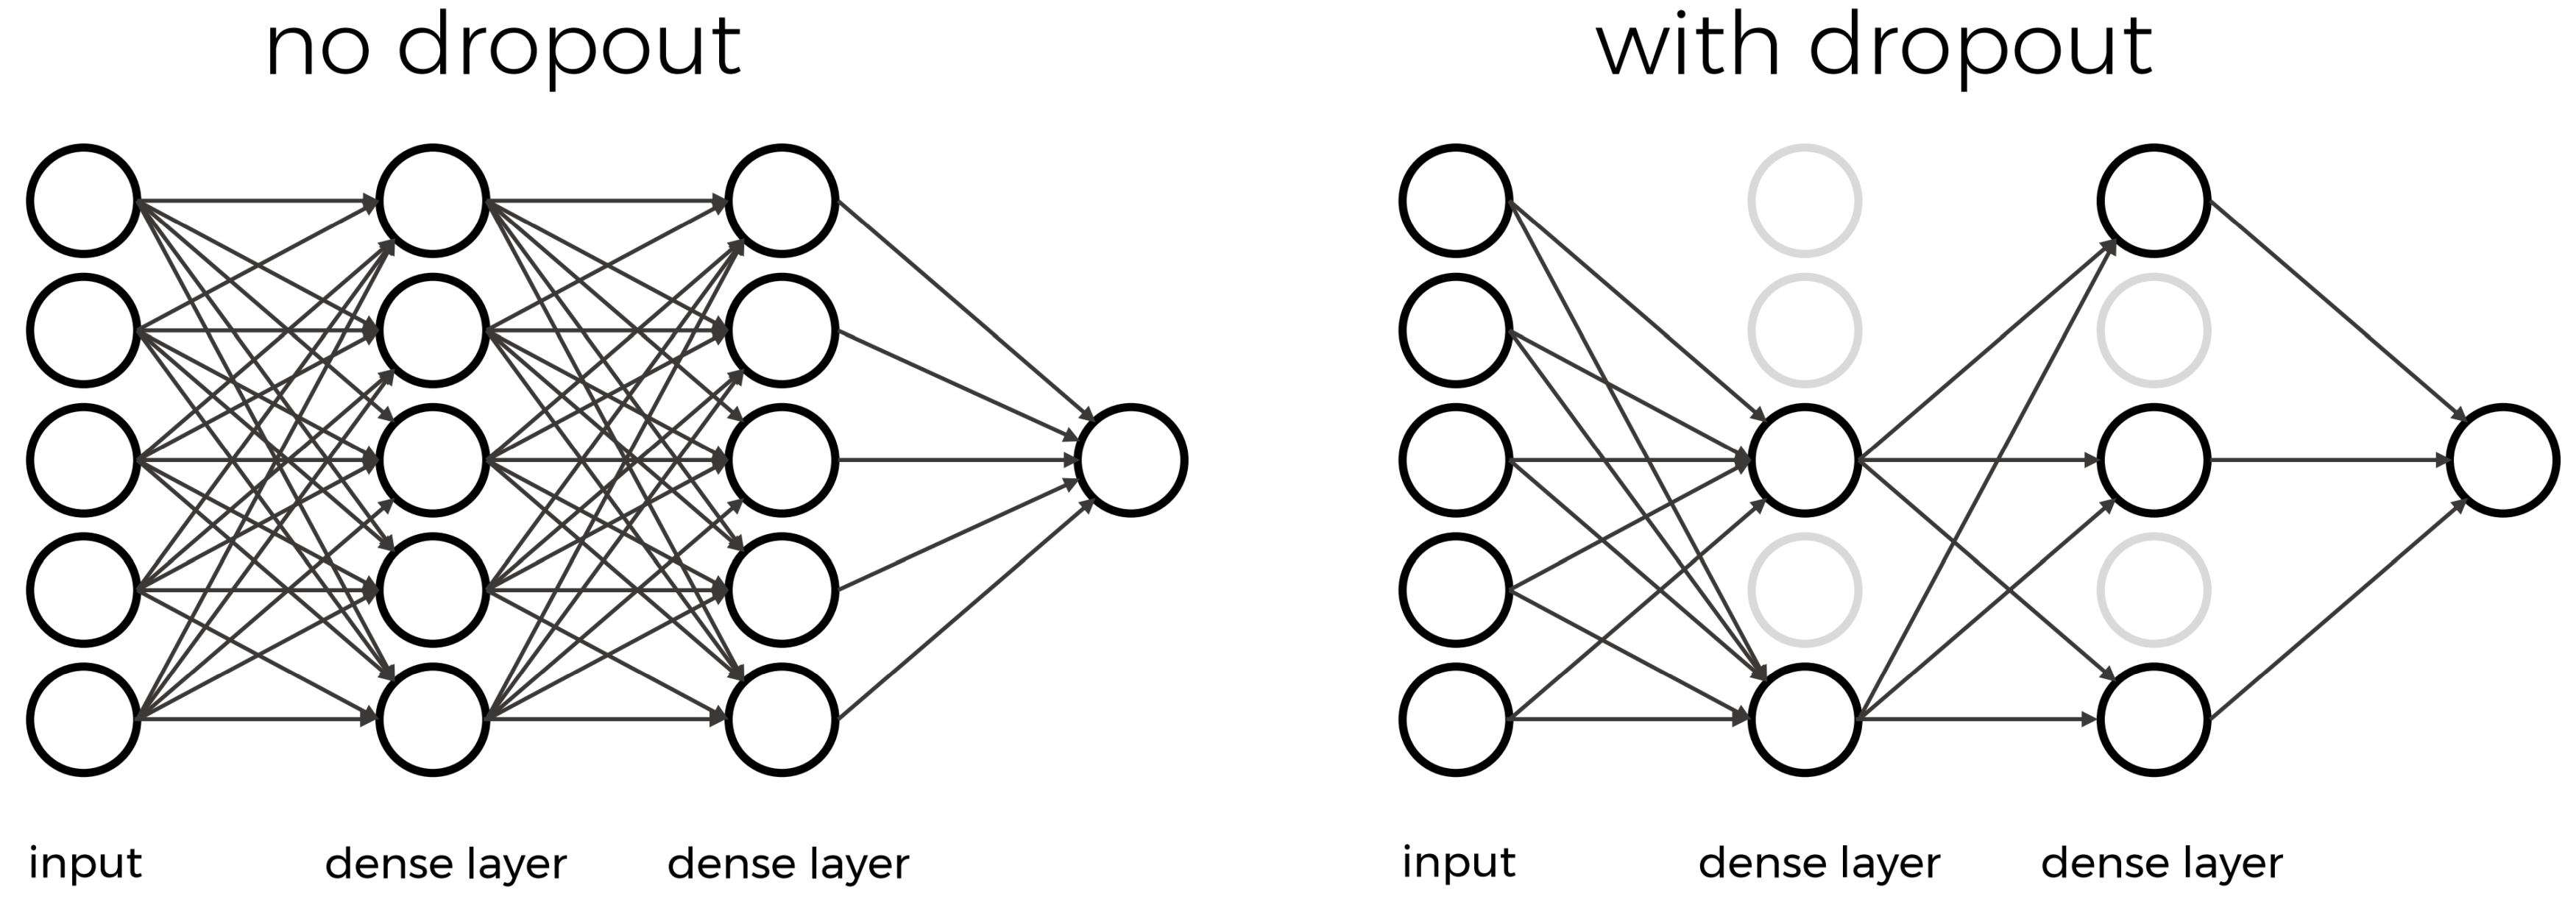

In [57]:
class Baseline(tf.keras.Model):
    def __init__(self, input_dim:int , embedding_dim:int, out_dim:int, max_seq_len:int, dropout_rate:int=0.2, embedding_type="vanilla"):
        super(Baseline, self).__init__()
        self.max_seq_len = max_seq_len
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)
        self.flatten = Flatten()
        self.embedding_dropout = Dropout(dropout_rate)
        self.embedding_proj = Dense(128, activation="gelu")
        self.embedding_proj_dropout = Dropout(dropout_rate)
        self.classifier = Dense(out_dim, activation="softmax")
        
    def get_seq_embeddings(self, x, training=False):
        x = self.embedding(x)
        x = self.embedding_dropout(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.embedding_proj_dropout(x, training)
        return x
    
    def call(self, inputs, training=False):
        return self.classifier(self.get_seq_embeddings(inputs, training))

### ProtCNN

One-hot encoding input : (Batch, Seq_length, Dim_amino_acids)

Model description: 

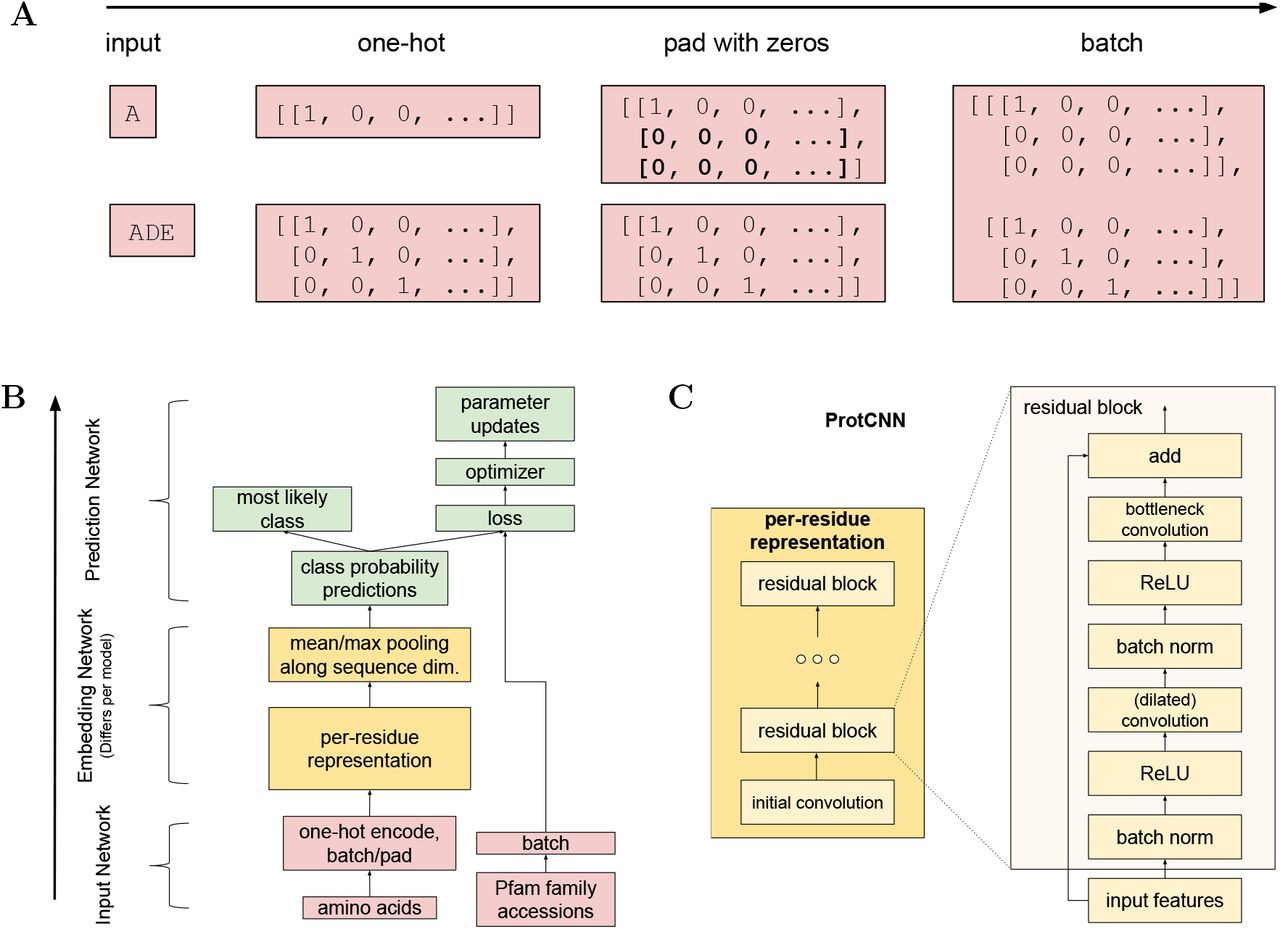

In [58]:
class ProtCNN(tf.keras.Model):
    def __init__(self, out_dim:int, dropout_rate:float =0.2):
        super(ProtCNN, self).__init__()

        self.conv1 = Conv1D(64, kernel_size=7, activation='relu', padding='same')
        self.pool1 = MaxPooling1D(2)
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(dropout_rate)
        
        self.conv2 = Conv1D(128, kernel_size=7, activation='relu', padding='same')
        self.pool2 = MaxPooling1D(2)
        self.bn2 = BatchNormalization()
        self.dropout2 = Dropout(dropout_rate)
        
        self.conv3 = Conv1D(256, kernel_size=7, activation='relu', padding='same')
        self.pool3 = GlobalAveragePooling1D()  
        self.bn3 = BatchNormalization()
        self.dropout3 = Dropout(dropout_rate)

        self.dense1 = Dense(256, activation='relu')
        self.dropout4 = Dropout(dropout_rate)

        self.classifier = Dense(out_dim, activation="softmax")
    
    def get_seq_embeddings(self, x, training:bool =False):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x, training=training)
        x = self.dropout3(x, training=training)

        x = self.dense1(x)
        x = self.dropout4(x, training=training)
        
        return x

    def call(self, inputs, training:bool =False):
        x = self.get_seq_embeddings(inputs, training)
        x = self.classifier(x)
        return x


### Bi-LSTM

Model description: 

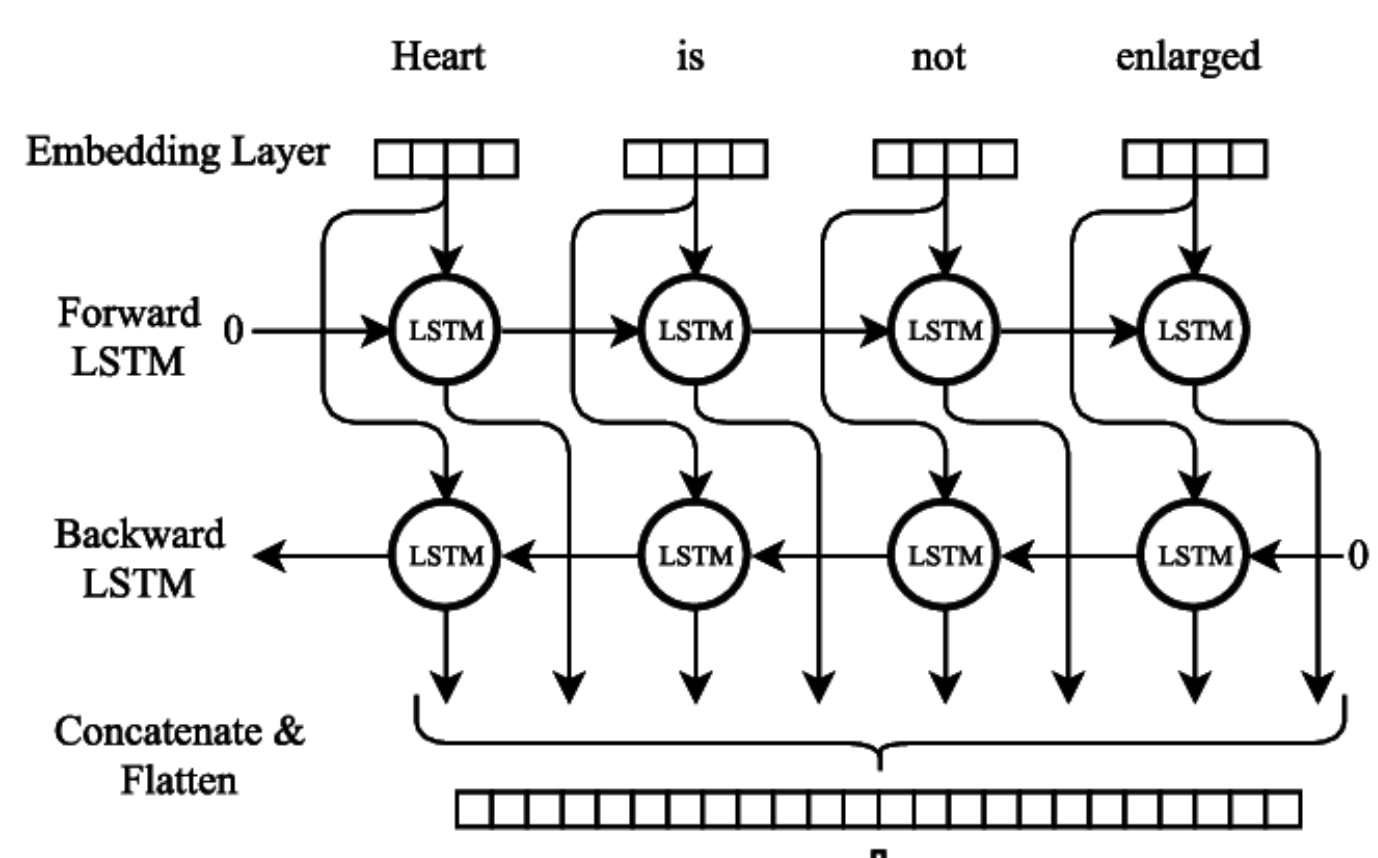

In [59]:
class BiLSTMClassifier(tf.keras.Model):
    def __init__(self, num_labels:int, max_length:int, embedding_dim:int =128, lstm_units:int =64, dropout_rate:float =0.2):
        super(BiLSTMClassifier, self).__init__()

        self.max_length = max_length
        
        self.embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embedding_dim, input_length=max_length)

        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))

        self.embedding_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.flatten = tf.keras.layers.Flatten()
        self.embedding_proj = tf.keras.layers.Dense(128, activation="relu")
        self.embedding_proj_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(num_labels, activation="softmax")

    def call(self, inputs, training:bool =False):
        x = self.get_seq_embeddings(inputs, training)
        x = self.classifier(x)
        return x

    def get_seq_embeddings(self, sequences, training:bool =False):
        x = self.embedding(sequences)
        x = self.bilstm(x)
        
        x = self.embedding_dropout(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.embedding_proj_dropout(x, training)

        return x


### Transformer

Model description: 

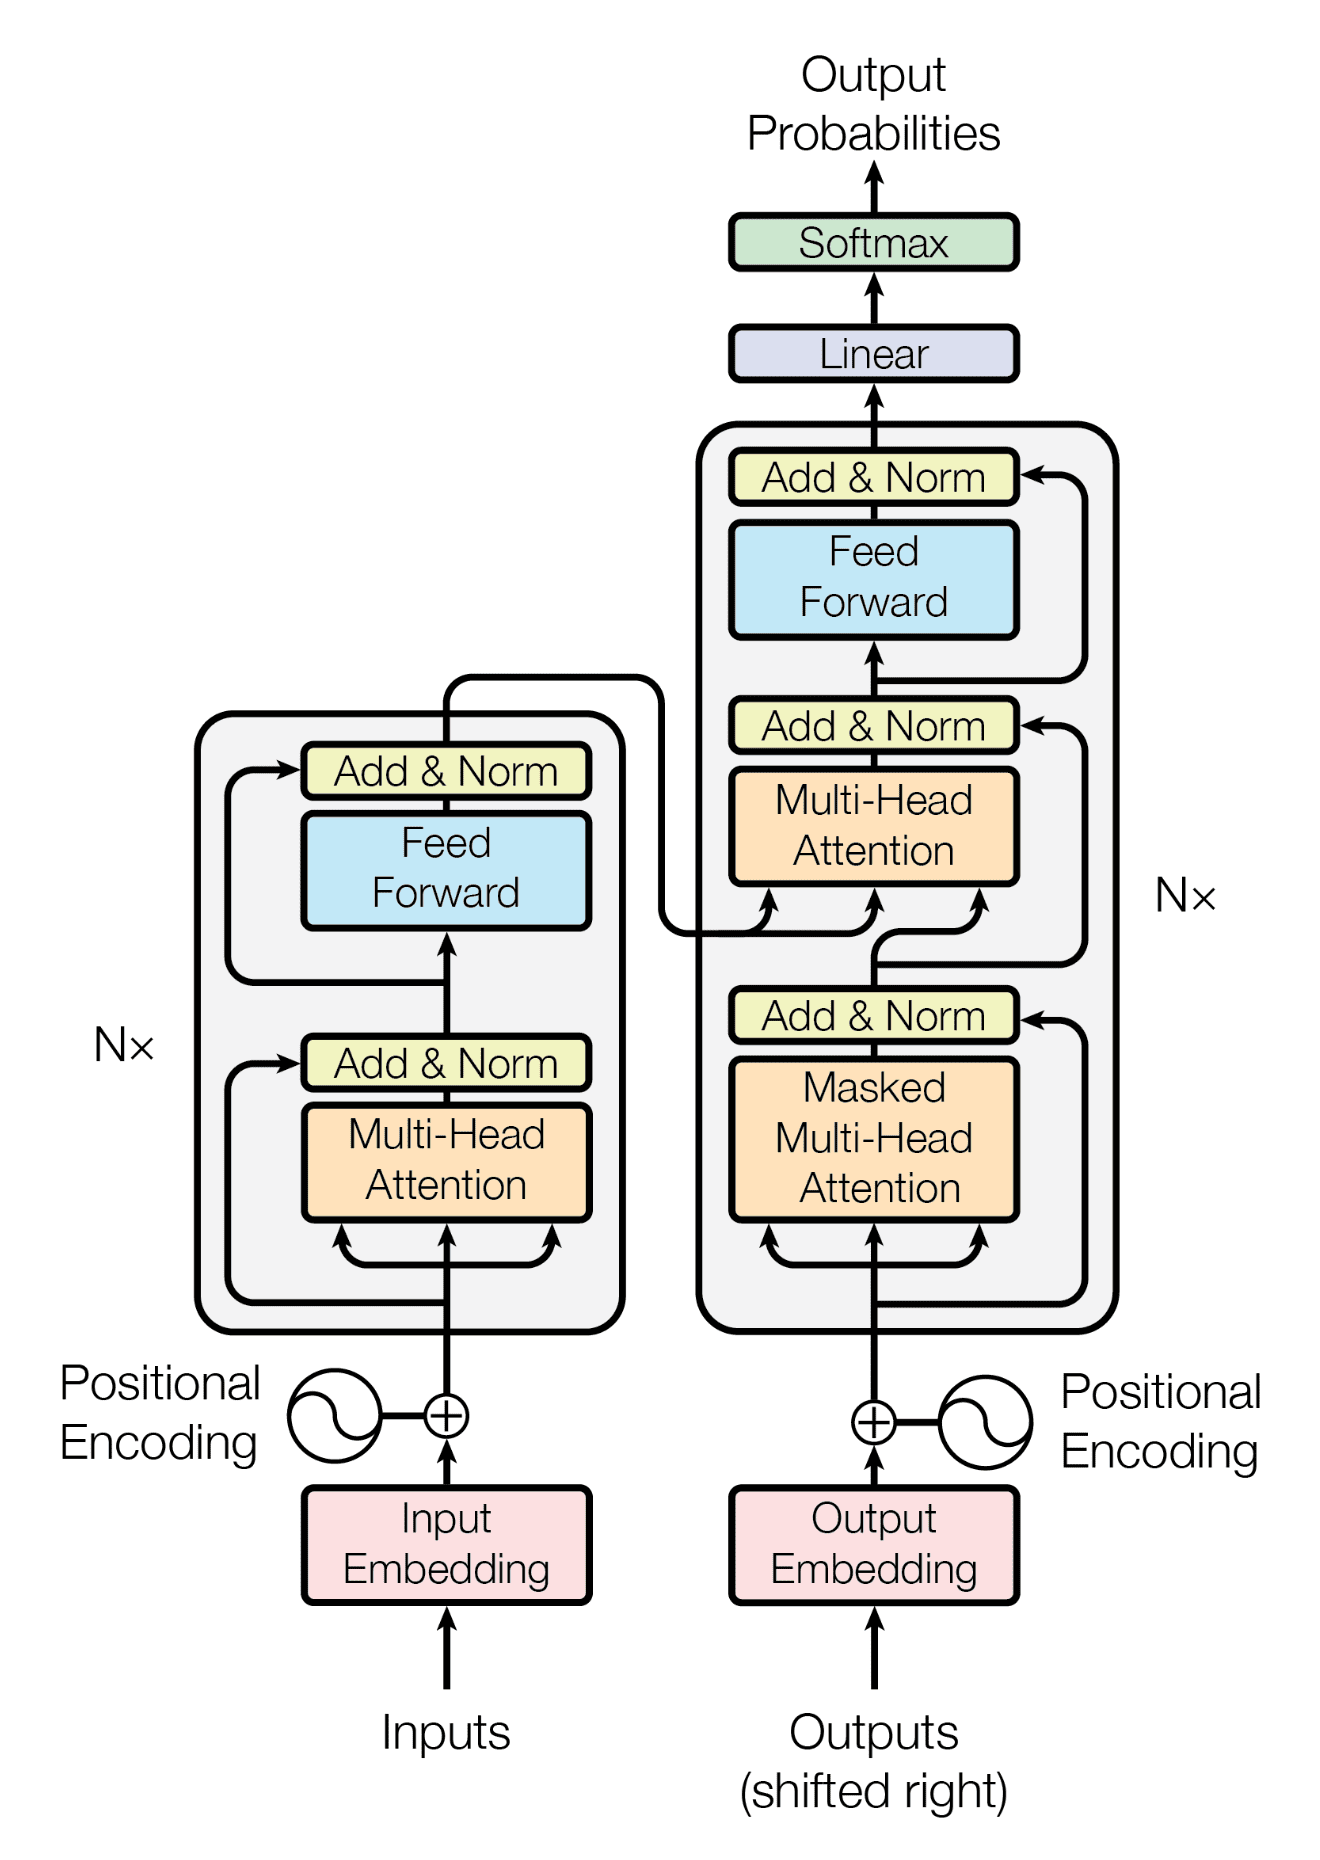

In [60]:
class PositionEmbeddingLayer(layers.Layer):
    def __init__(self, seq_length, input_dim, embedding_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.acid_embedding = Embedding(
            input_dim=input_dim, 
            output_dim=embedding_dim
        )
        self.pos_encoding = Embedding(
            input_dim=seq_length, 
            output_dim=embedding_dim
        )
 
    def call(self, inputs):
        seq_dim = tf.shape(inputs)[-1]
        position_indices = tf.range(seq_dim)
        acid_embeddings = self.acid_embedding(inputs)
        pos_encodings = self.pos_encoding(position_indices)
        return acid_embeddings + pos_encodings

In [61]:
class TransformerLayer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, mlp_dim, dropout_rate=0.2):
        super(TransformerLayer, self).__init__()
        self.mlh_attn = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embedding_dim)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout_rate),
            layers.Dense(embedding_dim),
            layers.Dropout(dropout_rate)
        ])
        self.attn_prenorm = layers.LayerNormalization(epsilon=1e-6)
        self.mlp_prenorm = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        x = inputs
        attn_prenorm = self.attn_prenorm(x)
        attn_out = self.mlh_attn(attn_prenorm, attn_prenorm)
        attn_out += x
        
        mlp_in = self.mlp_prenorm(attn_out)
        mlp_out = self.mlp(mlp_in)
        mlp_out += attn_out
        
        return mlp_out

In [62]:
class Transformer(tf.keras.Model):
    def __init__(self, input_dim:int, embedding_dim:int, out_dim:int, max_seq_len:int, dropout_rate:float =0.2, embedding_type:str ="vanilla", num_transformer_layers:int =2, num_attention_heads:int =4, transformer_mlp_dim:int =128):
        super(Transformer, self).__init__()
        self.max_seq_len = max_seq_len
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        if embedding_type == "positional":
            self.embedding = PositionEmbeddingLayer(
                seq_length = max_seq_len, 
                input_dim = len(acid_index) + 1, 
                embedding_dim = embedding_dim
            )
        else:
            self.embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)
        self.flatten = Flatten()
        self.embedding_dropout = Dropout(dropout_rate)
        
        self.transformers = [
            TransformerLayer(
                embedding_dim=embedding_dim, 
                num_heads=num_attention_heads, 
                mlp_dim=transformer_mlp_dim, 
                dropout_rate=dropout_rate
        ) for _ in range(num_transformer_layers)]
        
        self.embedding_proj = Dense(128, activation="gelu")
        self.embedding_proj_dropout = Dropout(dropout_rate)
        self.classifier = Dense(out_dim, activation="softmax")
        
    def get_seq_embeddings(self, x, training:bool =False):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        for transformer in self.transformers:
            x = transformer(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.embedding_proj_dropout(x, training)
        return x
    
    def call(self, inputs, training:bool =False):
        x = self.get_seq_embeddings(inputs, training)
        x = self.classifier(x)
        return x


### Pretrained model ProtBert...


Model description: 

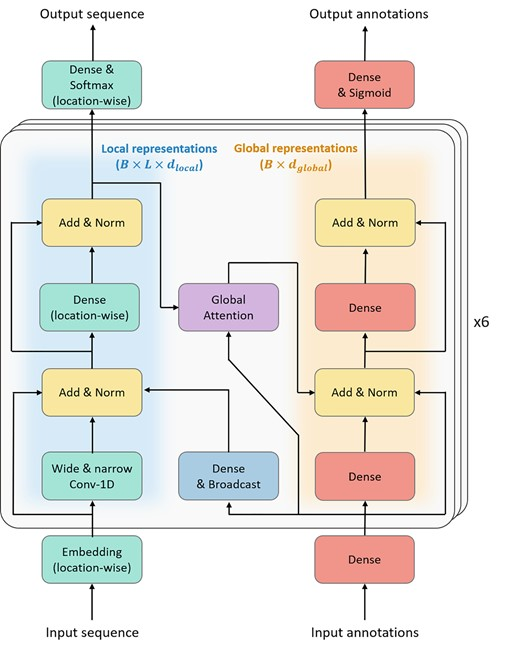!

In [63]:
class ProtBERTClassifier(tf.keras.Model):
    def __init__(self, num_labels:int, device:str ='CPU:0', quantize:bool =False, max_length:int =512):
        super(ProtBERTClassifier, self).__init__()

        self.device = device
        self.max_length = max_length

        with tf.device(self.device):
            self.tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
            config = BertConfig.from_pretrained("Rostlab/prot_bert", num_labels=num_labels)
            self.protbert = TFBertForSequenceClassification.from_pretrained("Rostlab/prot_bert", config=config, from_pt=True)
            self.protbert.trainable = False

            if quantize:
                for layer in self.protbert.layers:
                    if isinstance(layer, (tf.keras.layers.Embedding, tf.keras.layers.Dense)):
                        layer_weights = layer.get_weights()
                        layer.set_weights([tf.cast(w, tf.float16) for w in layer_weights])
        
        self.embedding_dropout = tf.keras.layers.Dropout(0.2)
        self.flatten = tf.keras.layers.Flatten()
        self.embedding_proj = tf.keras.layers.Dense(128, activation="relu")
        self.embedding_proj_dropout = tf.keras.layers.Dropout(0.2)
        self.classifier = tf.keras.layers.Dense(num_labels, activation="softmax")

    def call(self, inputs, training:bool =False):
        x = self.get_seq_embeddings(inputs, training)
        x = self.classifier(x)
        return x

    def get_seq_embeddings(self, inputs, training:bool =False):
        input_ids, attention_mask = inputs
        
        with tf.device(self.device):
            outputs = self.protbert(input_ids, attention_mask=attention_mask)
            x = outputs[0]

        x = self.embedding_dropout(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.embedding_proj_dropout(x, training)
        
        return x

## Experiment Description

**Loss function:** We will use loss="categorical_crossentropy" for every models, even though I would (with more time) select the loss the most adapted for the problem (especially check weighted loss given the distribition of labels across the data)

**Learning rate:** We will use the default learning rate '1e-3' (if the learning rate is not explicitly mention)

#### Simple Baseline

#### Model Parameters

In [64]:
embedding_dim = 32
input_dim=len(acid_index) + 1

#### Training config

In [65]:
max_epochs = 10
batch_size = 32
patience = 5

In [66]:
# TODO : explain why top k metrics given large number of classes

metrics = ["accuracy",
            tf.keras.metrics.Precision(name='precision'),
            # tf.keras.metrics.Precision(name='precision_top_k=3', top_k=3),
            tf.keras.metrics.Recall(name='recall'),
            # tf.keras.metrics.Recall(name='recall_top_k=3', top_k=3),
            tfa.metrics.F1Score(name='f1_score', num_classes=num_labels, average='micro')
          ]

In [69]:
baseline_model = Baseline(
    input_dim = input_dim,
    embedding_dim = embedding_dim,
    out_dim = num_labels,
    max_seq_len = max_seq_len
)
# baseline_model(x_train[:0])
baseline_model.build(input_shape=(batch_size, max_seq_len,))
baseline_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)
baseline_model.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  672       
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  1228928   
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
Total params: 1,246,112
Trainable params: 1,246,112
Non-tr

The difference between the number of parameters is due to the Resnet module which reduce/increase the size of our original vector (in our case increase due to the resnet parameters : filter_size and kernel_size since the one_hot_encoding is of 21)

In [70]:
## TODO : set up a tensorboard

In [71]:
baseline_history = baseline_model.fit(
    x_train, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/10
3502/3502 [==============================] - 23s 5ms/step - loss: 0.2519 - accuracy: 0.9448 - precision: 0.9905 - recall: 0.9194 - f1_score: 0.9448 - val_loss: 0.0257 - val_accuracy: 0.9935 - val_precision: 0.9968 - val_recall: 0.9921 - val_f1_score: 0.9935
Epoch 2/10
3502/3502 [==============================] - 18s 5ms/step - loss: 0.0237 - accuracy: 0.9935 - precision: 0.9950 - recall: 0.9923 - f1_score: 0.9935 - val_loss: 0.0279 - val_accuracy: 0.9928 - val_precision: 0.9949 - val_recall: 0.9922 - val_f1_score: 0.9928
Epoch 3/10
3502/3502 [==============================] - 18s 5ms/step - loss: 0.0203 - accuracy: 0.9939 - precision: 0.9949 - recall: 0.9932 - f1_score: 0.9939 - val_loss: 0.0327 - val_accuracy: 0.9930 - val_precision: 0.9942 - val_recall: 0.9923 - val_f1_score: 0.9930
Epoch 4/10
3502/3502 [==============================] - 18s 5ms/step - loss: 0.0183 - accuracy: 0.9945 - precision: 0.9951 - recall: 0.9940 - f1_score: 0.9945 - val_loss: 0.0296 - val_accuracy:

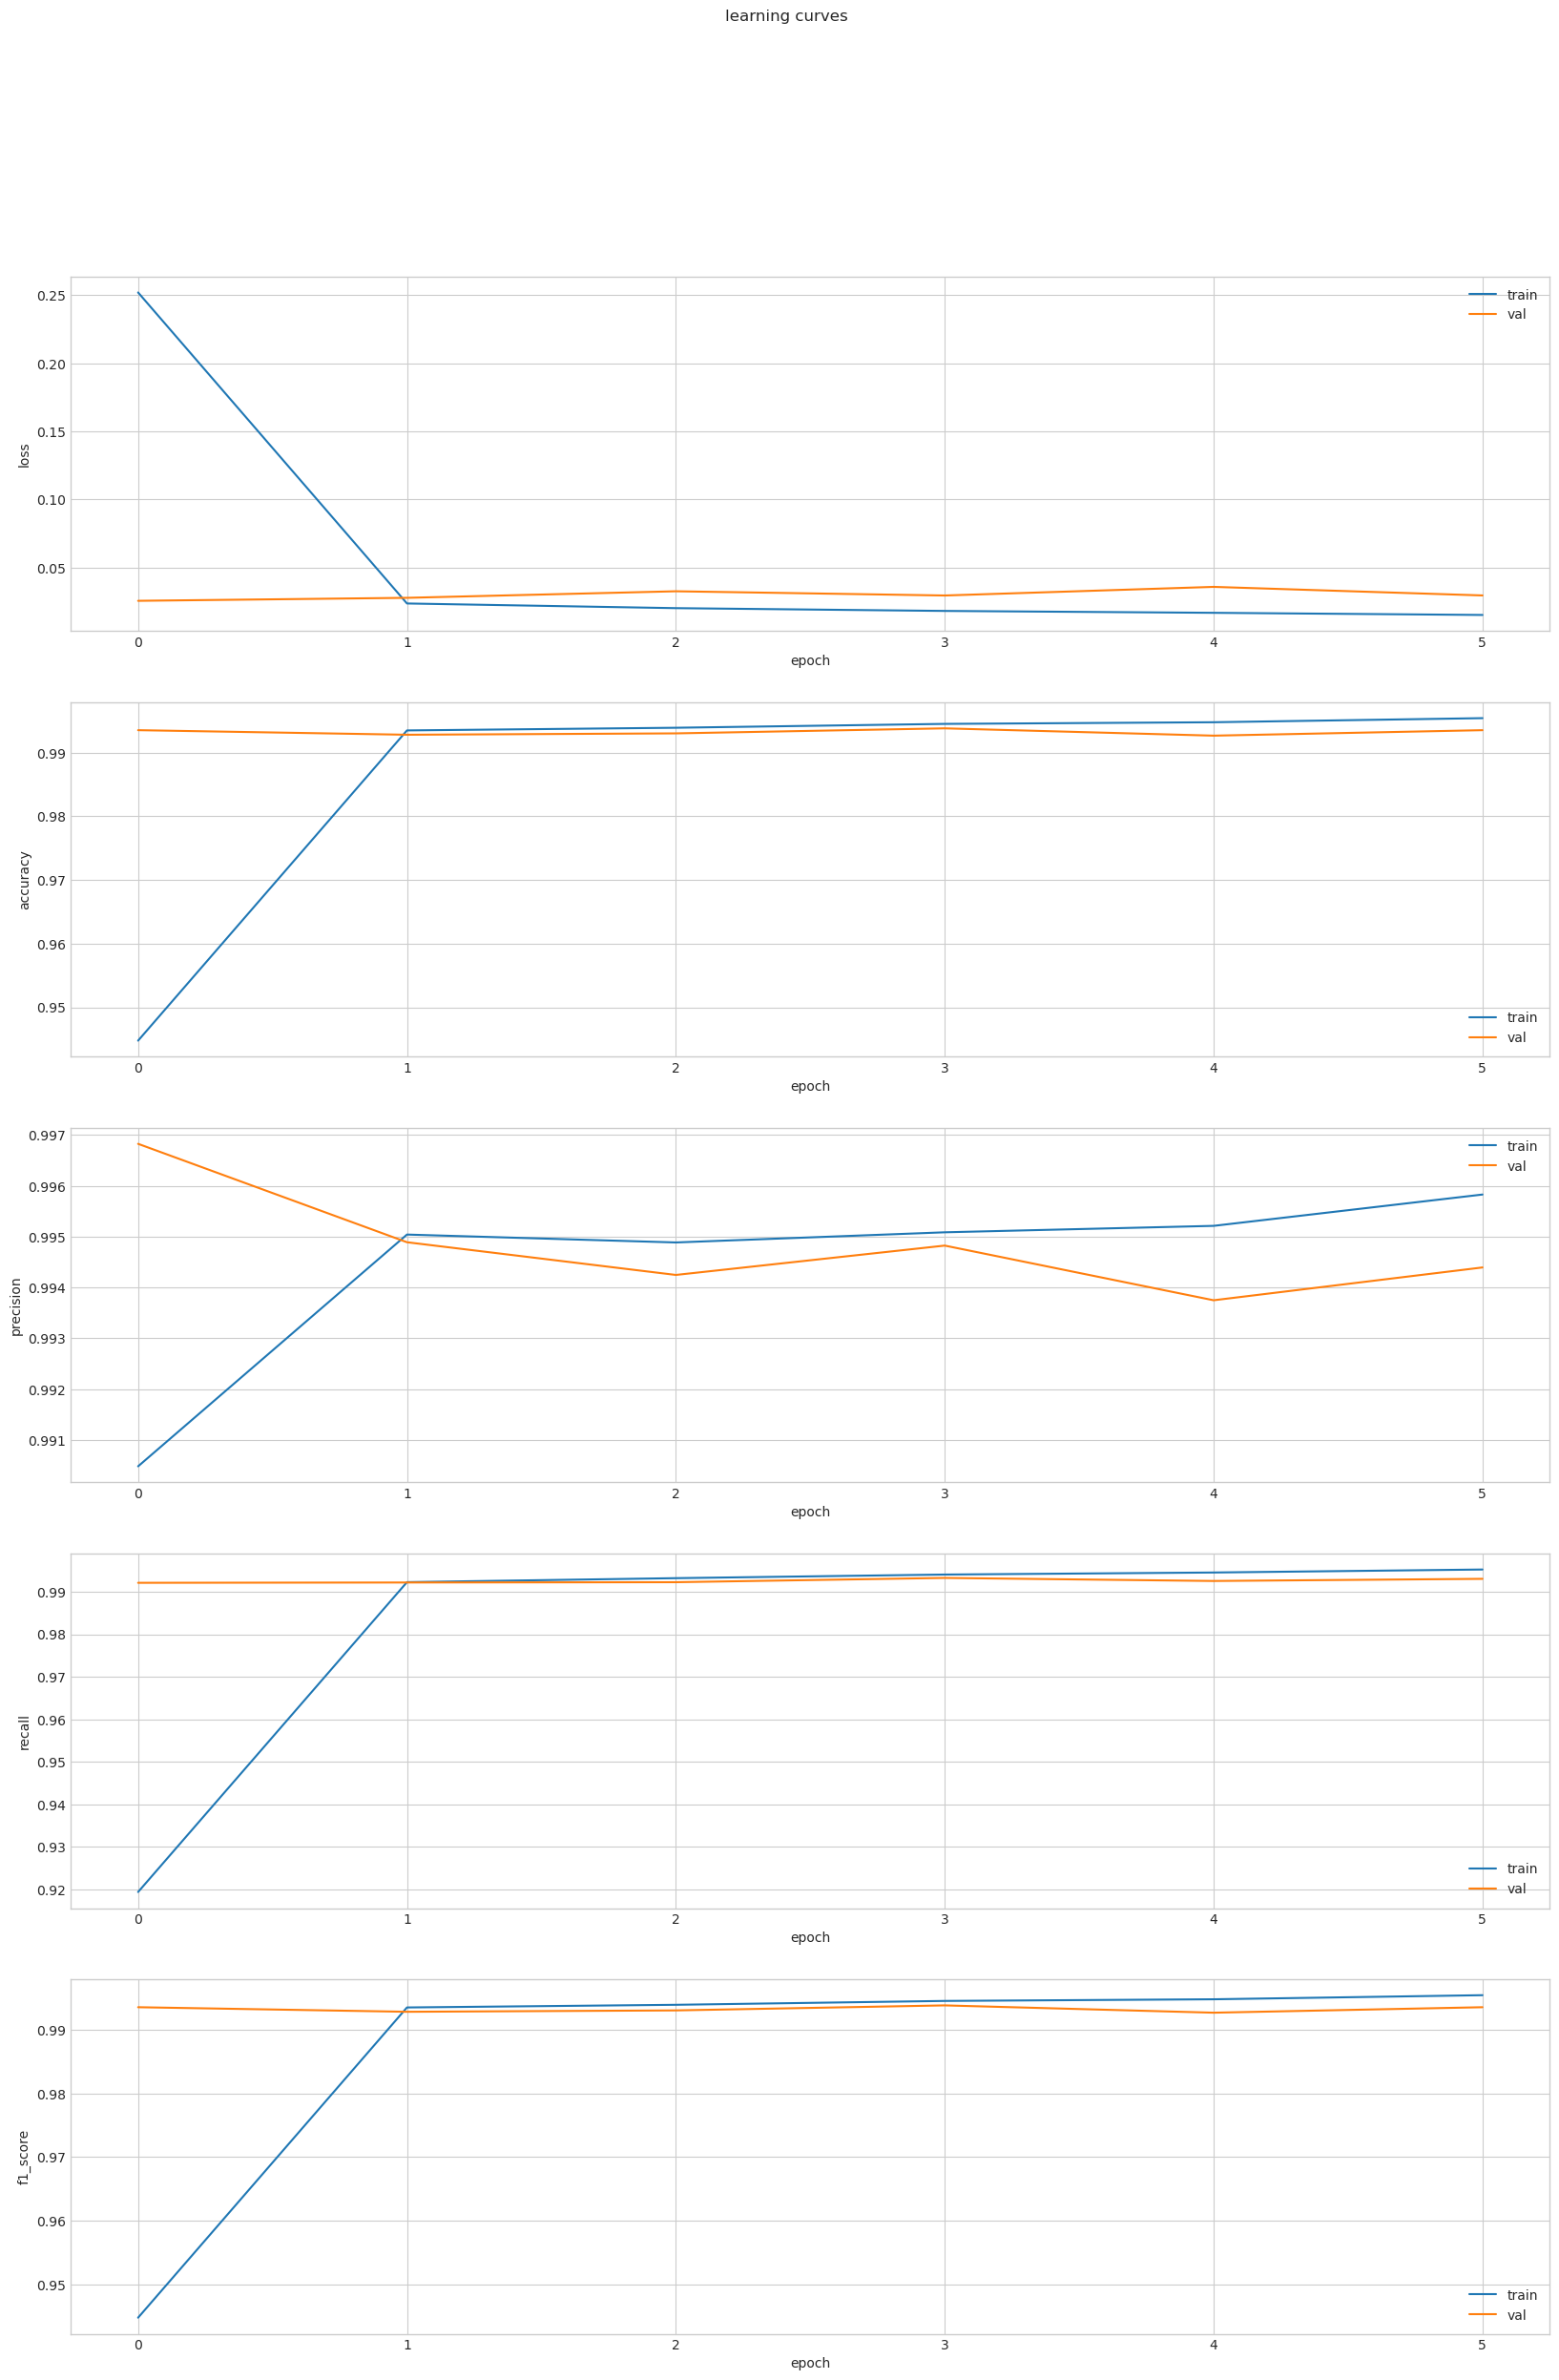

In [72]:
plot_history(baseline_history)

It seems that the model starts overfitting quite early. However, we are fine since we are using early stopping and validation accuracy seems promising.

Now, let us examine the performance of this simple model on the test set.

In [73]:
test = baseline_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

436/436 [==============================] - 2s 3ms/step - loss: 0.0227 - accuracy: 0.9944 - precision: 0.9971 - recall: 0.9929 - f1_score: 0.9944


In my opinion, test performance of such a simple model is quite surprising.
Let us visualise pre-classifier embeddings (embeddings of each sequence) to get some intuition about our model.


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 800x800 with 0 Axes>

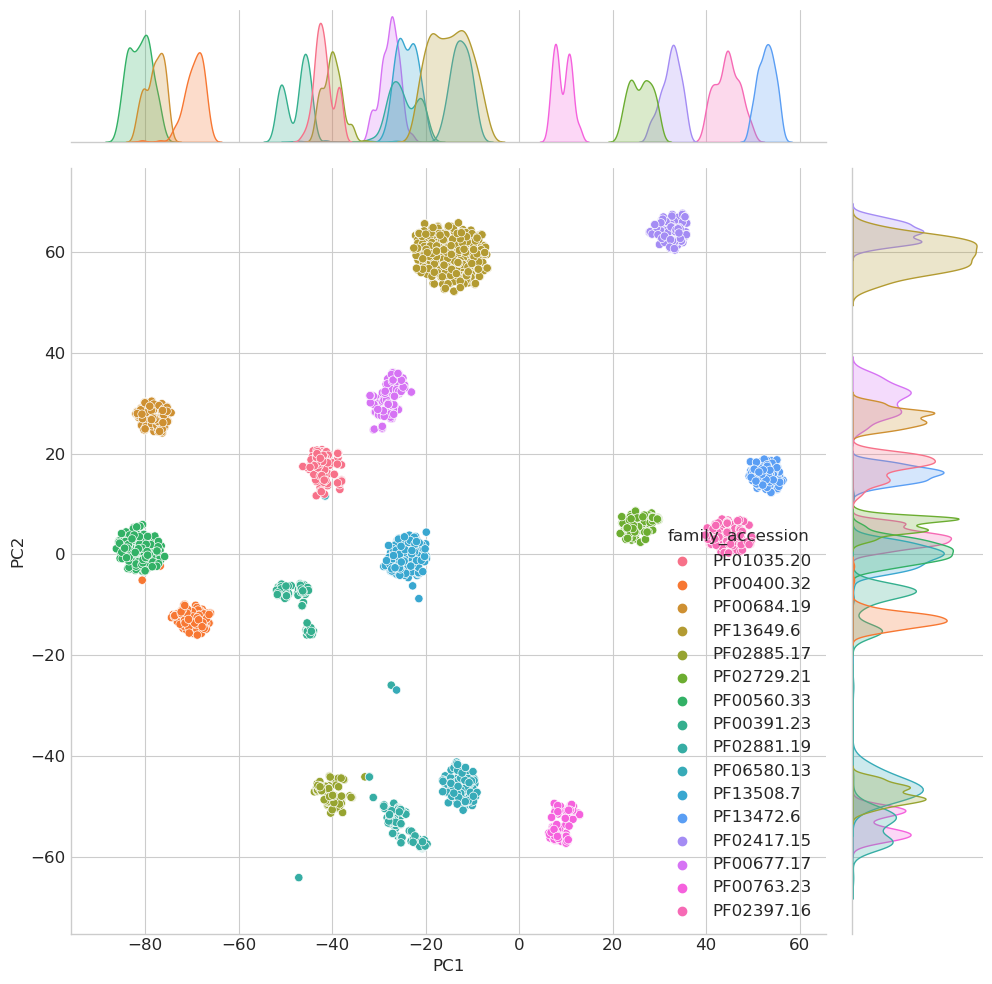

In [74]:
visualize_seq_embeddings(baseline_model, num_most_frequent_labels=16)

We can see clusters of sequences belonging to the same label, and clusters are nicely separated, which is consistent with the performance on the test set. 

#### ProtCNN

In [78]:
protcnn = ProtCNN(
    out_dim = num_labels,
)
protcnn.build(input_shape=(batch_size, max_seq_len, input_dim))

# TODO : explain why specific optimiser

protcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, weight_decay=0.001),
    # Why that ? : https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
    loss="categorical_crossentropy", 
    metrics=metrics
)
protcnn.summary()

Model: "prot_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           multiple                  9472      
                                                                 
 max_pooling1d_2 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 batch_normalization_3 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 conv1d_4 (Conv1D)           multiple                  57472     
                                                                 
 max_pooling1d_3 (MaxPooling  multiple                 0

In [79]:
protcnn_history = protcnn.fit(
    x_train_one_hot, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev_one_hot, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/10
3502/3502 [==============================] - 42s 10ms/step - loss: 1.5785 - accuracy: 0.5736 - precision: 0.8226 - recall: 0.5370 - f1_score: 0.6202 - val_loss: 0.1730 - val_accuracy: 0.9497 - val_precision: 0.9605 - val_recall: 0.9417 - val_f1_score: 0.9497
Epoch 2/10
3502/3502 [==============================] - 32s 9ms/step - loss: 0.5133 - accuracy: 0.8705 - precision: 0.8949 - recall: 0.8550 - f1_score: 0.8705 - val_loss: 0.1122 - val_accuracy: 0.9721 - val_precision: 0.9755 - val_recall: 0.9704 - val_f1_score: 0.9721
Epoch 3/10
3502/3502 [==============================] - 32s 9ms/step - loss: 0.4513 - accuracy: 0.9030 - precision: 0.9159 - recall: 0.8959 - f1_score: 0.9030 - val_loss: 1.2155 - val_accuracy: 0.8802 - val_precision: 0.8856 - val_recall: 0.8781 - val_f1_score: 0.8802
Epoch 4/10
3502/3502 [==============================] - 32s 9ms/step - loss: 0.4518 - accuracy: 0.9161 - precision: 0.9256 - recall: 0.9114 - f1_score: 0.9161 - val_loss: 0.0948 - val_accuracy

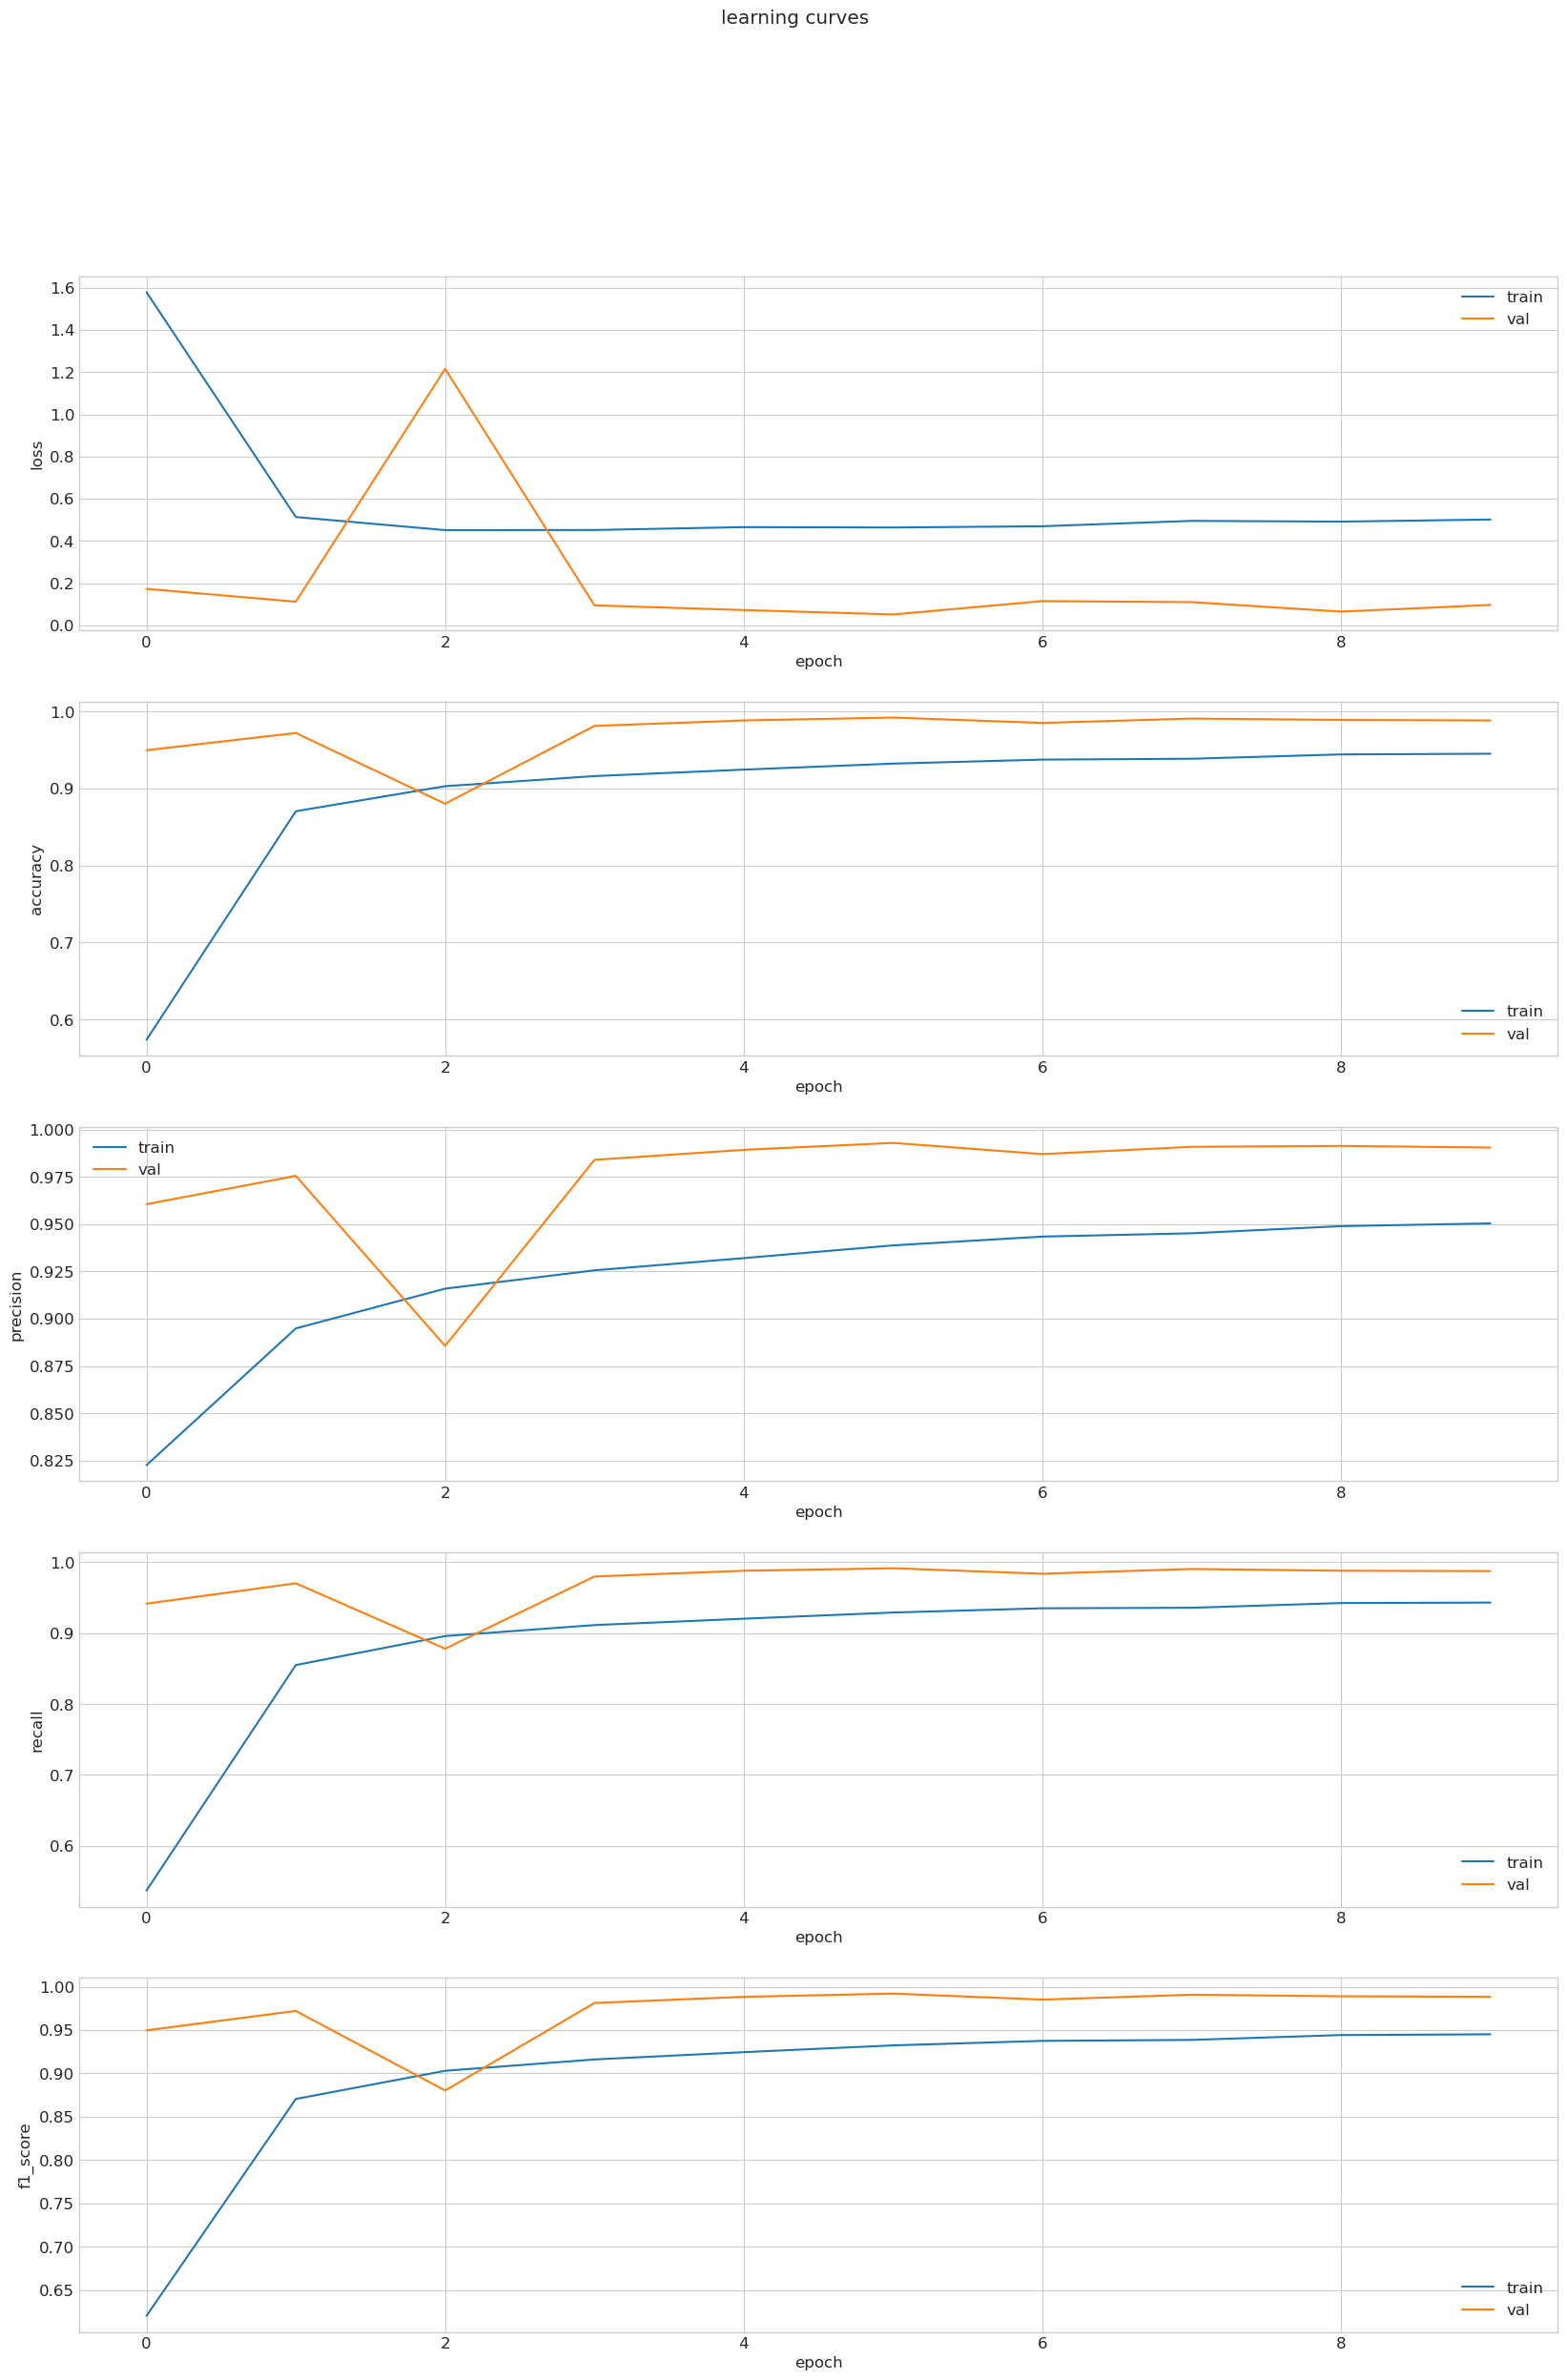

In [82]:
plot_history(protcnn_history)

In [83]:
test_one_hot = protcnn.evaluate(x_test_one_hot, y_test, batch_size=batch_size, verbose=1)

436/436 [==============================] - 2s 5ms/step - loss: 0.0783 - accuracy: 0.9909 - precision: 0.9915 - recall: 0.9901 - f1_score: 0.9909


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 800x800 with 0 Axes>

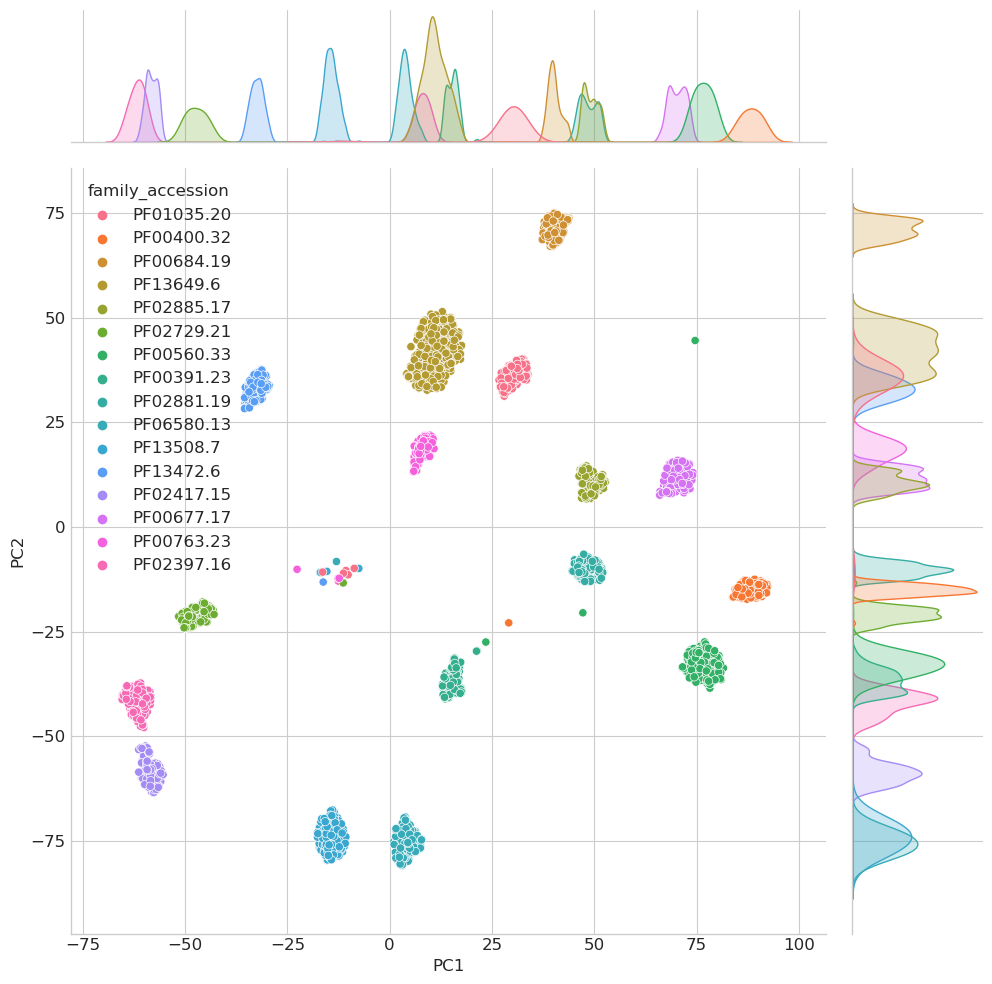

In [84]:
visualize_seq_embeddings(protcnn, num_most_frequent_labels=16, one_hot=True)

### Bi-LSTM

In [90]:
bilstm = BiLSTMClassifier(num_labels, max_seq_len, embedding_dim=128, lstm_units=64, dropout_rate=0.2)
bilstm.build(input_shape=(batch_size, max_seq_len,))
bilstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)
bilstm.summary()

Model: "bi_lstm_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  38400     
                                                                 
 bidirectional (Bidirectiona  multiple                 98816     
 l)                                                              
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  4915328   
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                

In [91]:
bilstm_history = bilstm.fit(
    x_train, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/10
3502/3502 [==============================] - 134s 37ms/step - loss: 0.1938 - accuracy: 0.9522 - precision: 0.9839 - recall: 0.9467 - f1_score: 0.9566 - val_loss: 0.0232 - val_accuracy: 0.9940 - val_precision: 0.9952 - val_recall: 0.9933 - val_f1_score: 0.9940
Epoch 2/10
3502/3502 [==============================] - 128s 36ms/step - loss: 0.0346 - accuracy: 0.9905 - precision: 0.9919 - recall: 0.9898 - f1_score: 0.9905 - val_loss: 0.0219 - val_accuracy: 0.9943 - val_precision: 0.9946 - val_recall: 0.9940 - val_f1_score: 0.9943
Epoch 3/10
3502/3502 [==============================] - 128s 37ms/step - loss: 0.0243 - accuracy: 0.9937 - precision: 0.9944 - recall: 0.9934 - f1_score: 0.9937 - val_loss: 0.0240 - val_accuracy: 0.9950 - val_precision: 0.9957 - val_recall: 0.9948 - val_f1_score: 0.9950
Epoch 4/10
3502/3502 [==============================] - 128s 37ms/step - loss: 0.0204 - accuracy: 0.9947 - precision: 0.9951 - recall: 0.9945 - f1_score: 0.9947 - val_loss: 0.0194 - val_a

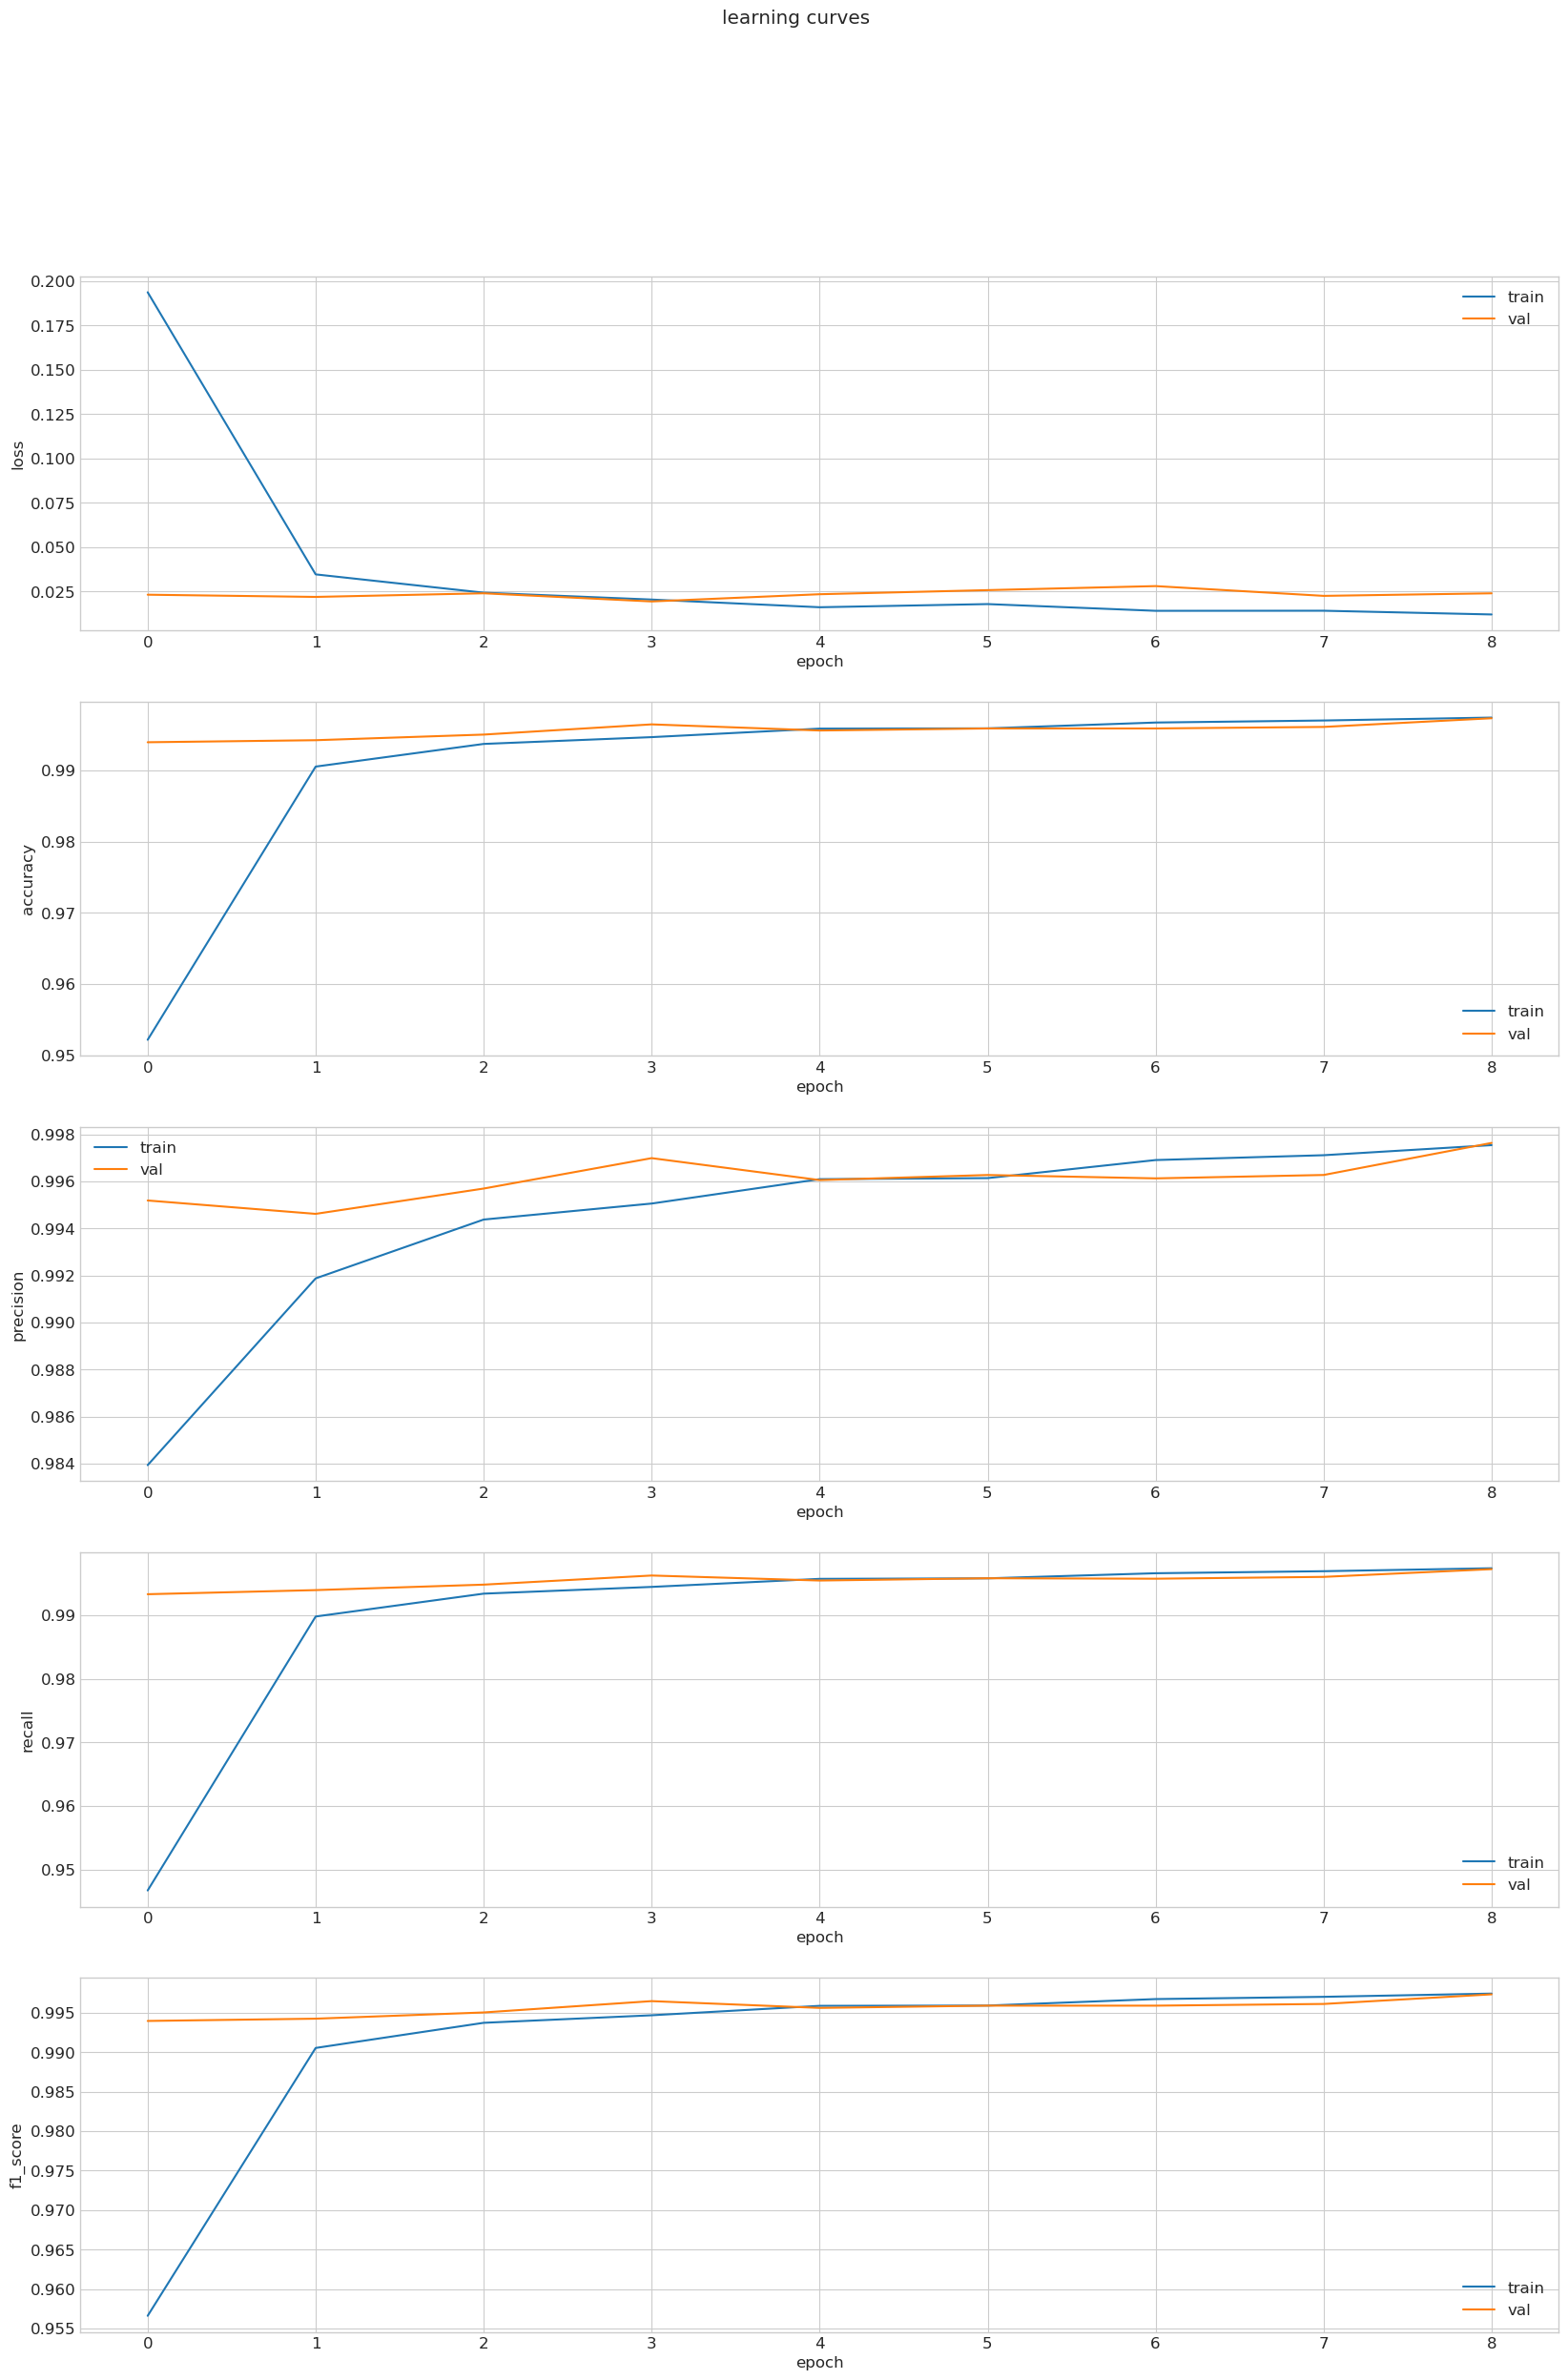

In [92]:
plot_history(bilstm_history)

In [93]:
bilstm_test = bilstm.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

436/436 [==============================] - 6s 13ms/step - loss: 0.0212 - accuracy: 0.9959 - precision: 0.9964 - recall: 0.9958 - f1_score: 0.9959


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 800x800 with 0 Axes>

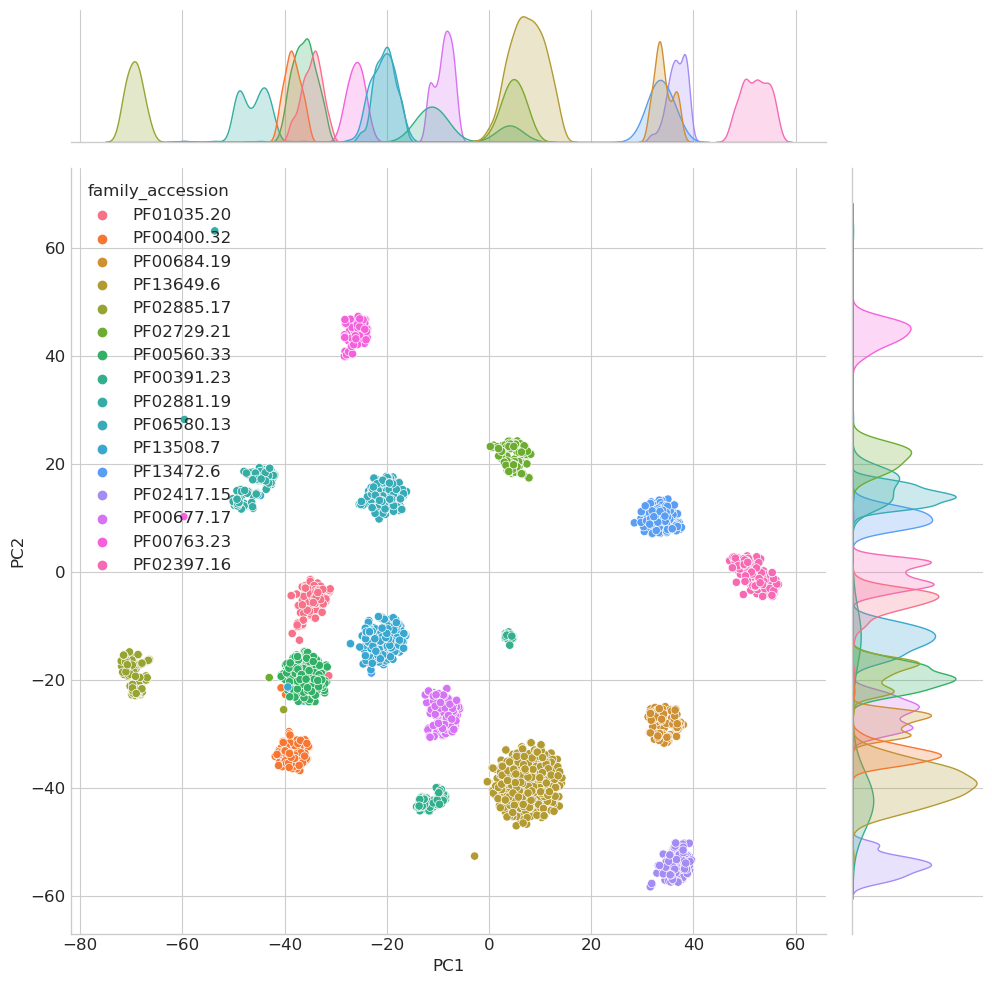

In [94]:
visualize_seq_embeddings(bilstm, num_most_frequent_labels=16)

Pros:

Cons:

### Transformer Encoder

In [95]:
transformer_model = Transformer(input_dim, embedding_dim, num_labels, max_seq_len, embedding_type="positional")
transformer_model.build(input_shape=(batch_size, max_seq_len,))
transformer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)
transformer_model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_layer_1   multiple                 10272     
 (PositionEmbeddingLayer)                                        
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dropout_14 (Dropout)        multiple                  0         
                                                                 
 transformer_layer (Transfor  multiple                 25280     
 merLayer)                                                       
                                                                 
 transformer_layer_1 (Transf  multiple                 25280     
 ormerLayer)                                                     
                                                       

Since we are about to train a more complex model, let us increase the number of epochs.

In [96]:
max_epochs = 15

In [97]:
history_transformer = transformer_model.fit(
    x_train, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/15
3502/3502 [==============================] - 84s 22ms/step - loss: 1.2383 - accuracy: 0.7133 - precision: 0.9470 - recall: 0.7115 - f1_score: 0.7445 - val_loss: 0.0879 - val_accuracy: 0.9801 - val_precision: 0.9858 - val_recall: 0.9779 - val_f1_score: 0.9801
Epoch 2/15
3502/3502 [==============================] - 75s 21ms/step - loss: 0.1528 - accuracy: 0.9601 - precision: 0.9702 - recall: 0.9548 - f1_score: 0.9601 - val_loss: 0.0643 - val_accuracy: 0.9864 - val_precision: 0.9893 - val_recall: 0.9856 - val_f1_score: 0.9864
Epoch 3/15
3502/3502 [==============================] - 75s 22ms/step - loss: 0.1054 - accuracy: 0.9728 - precision: 0.9777 - recall: 0.9702 - f1_score: 0.9728 - val_loss: 0.0590 - val_accuracy: 0.9883 - val_precision: 0.9899 - val_recall: 0.9877 - val_f1_score: 0.9883
Epoch 4/15
3502/3502 [==============================] - 75s 21ms/step - loss: 0.0829 - accuracy: 0.9788 - precision: 0.9816 - recall: 0.9775 - f1_score: 0.9788 - val_loss: 0.0781 - val_accur

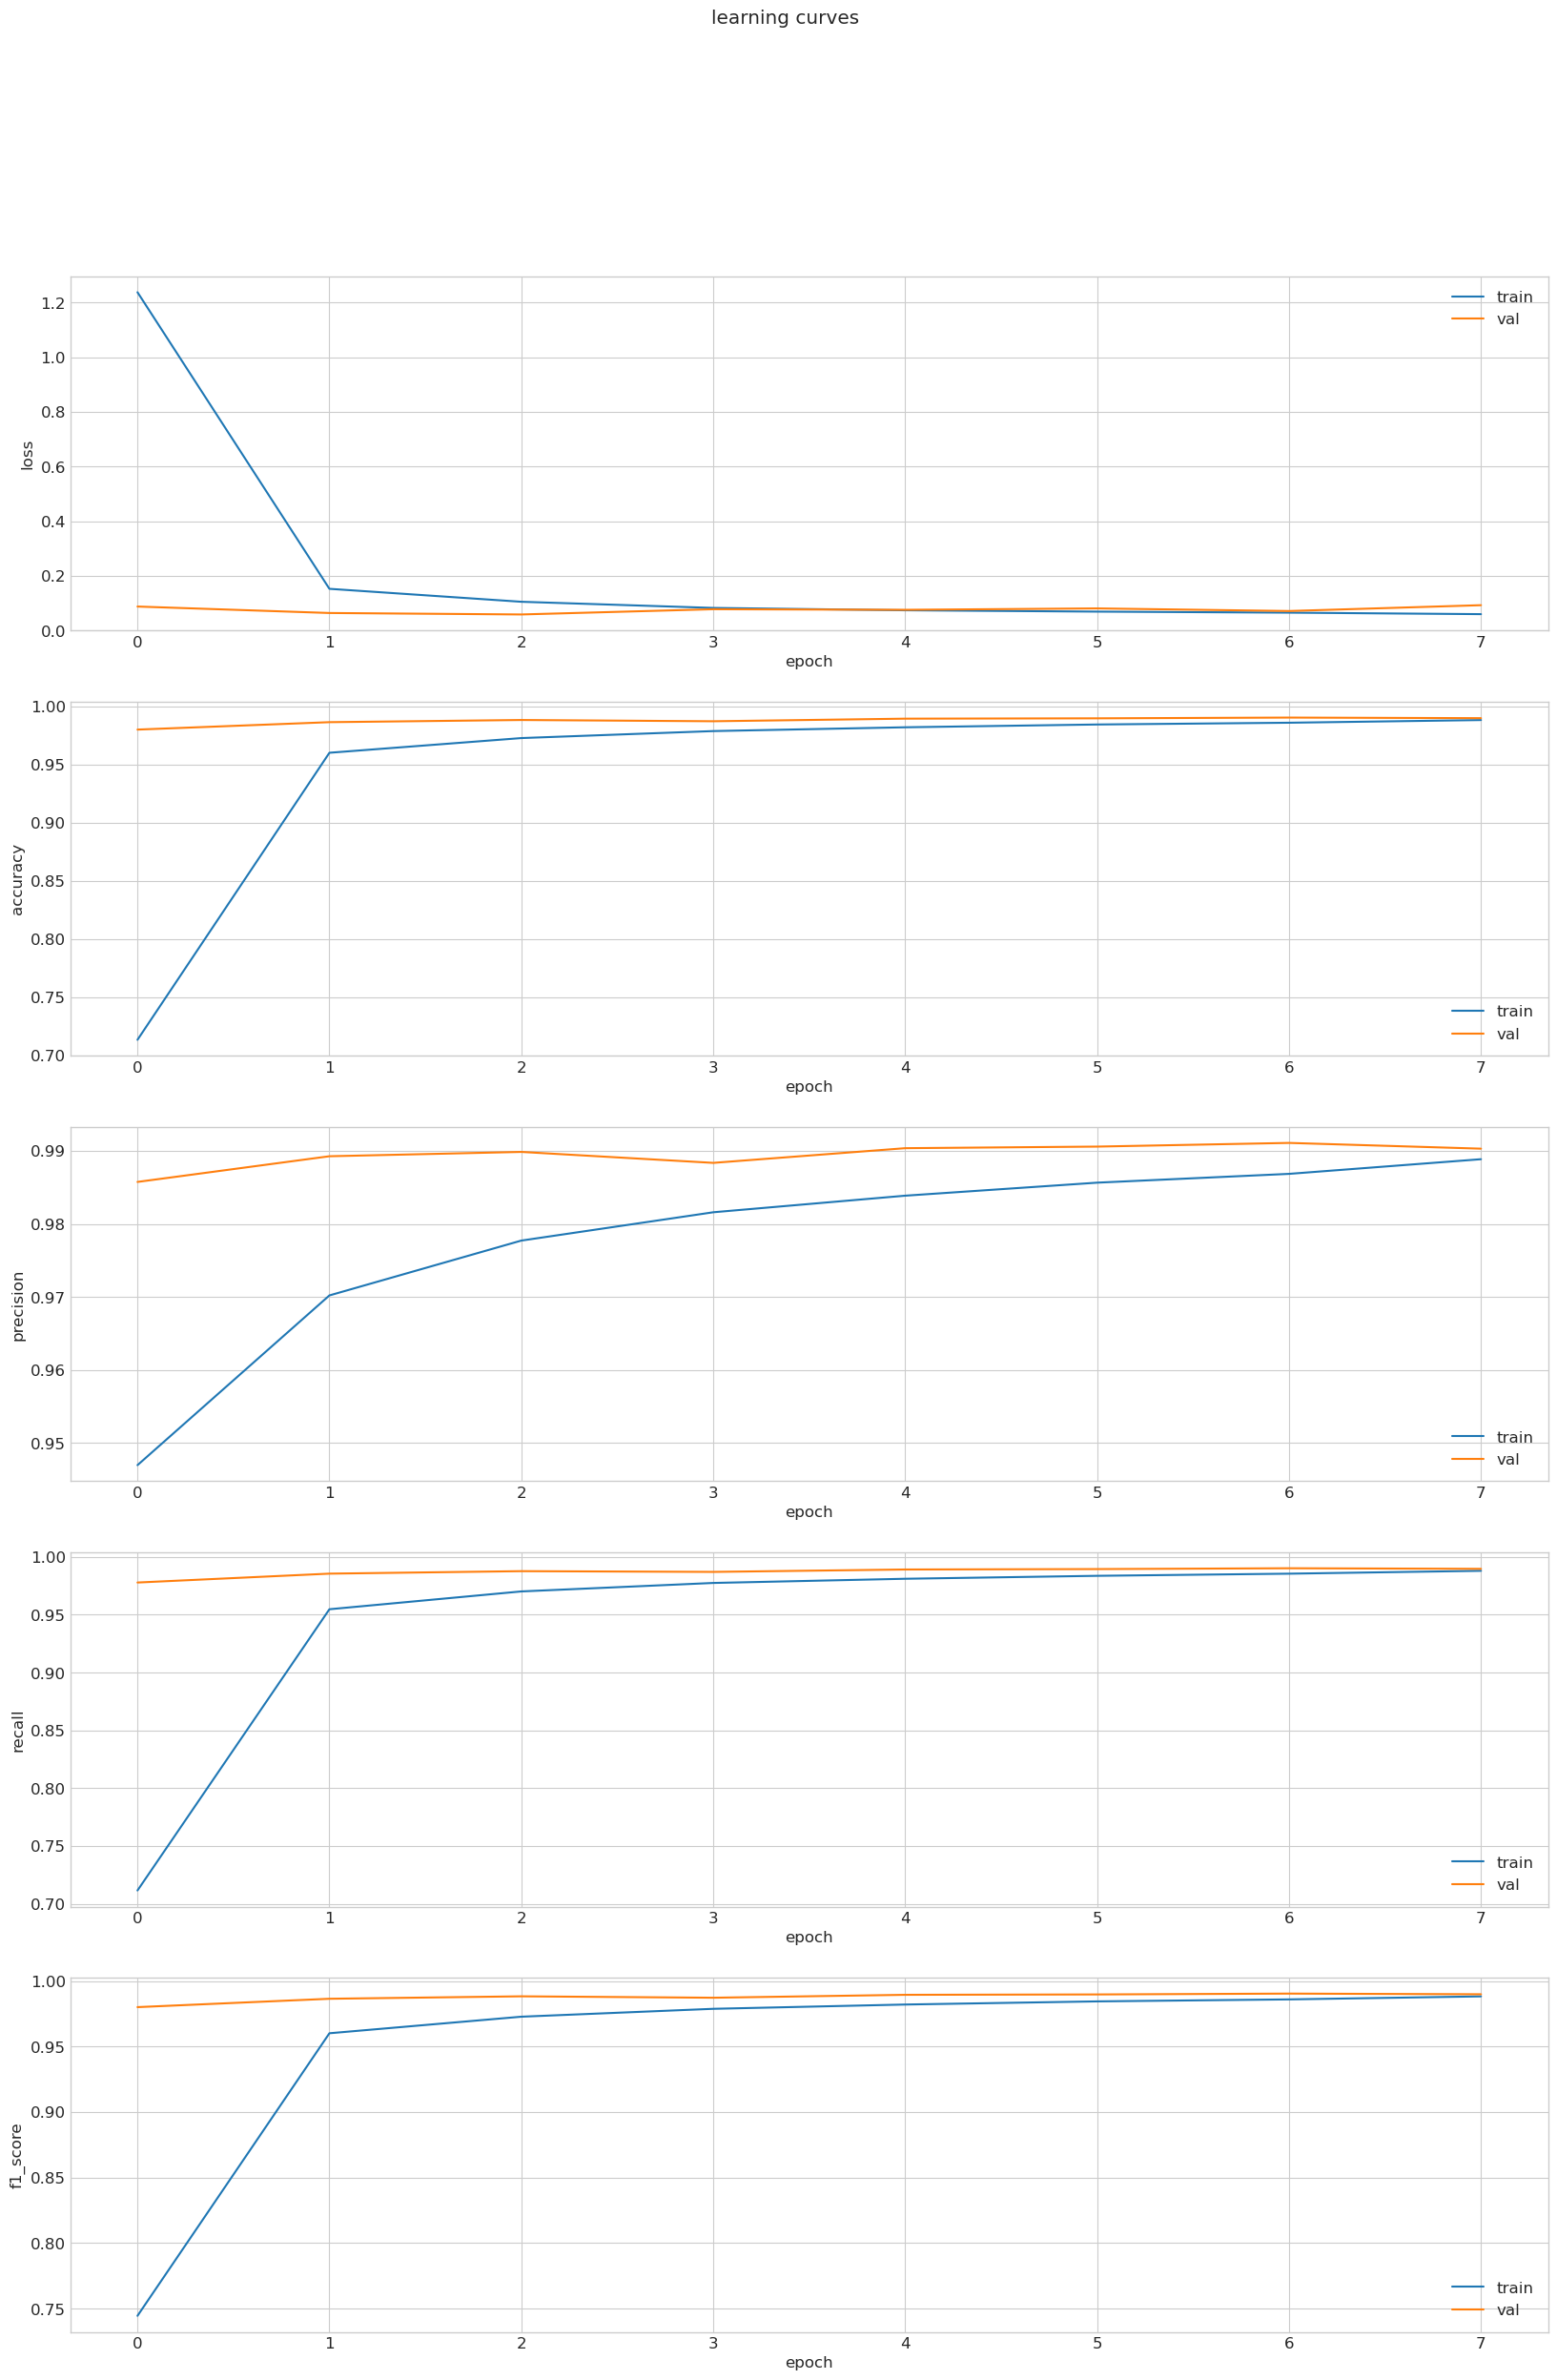

In [98]:
plot_history(history_transformer)

In [99]:
transformer_test = transformer_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

436/436 [==============================] - 4s 10ms/step - loss: 0.0502 - accuracy: 0.9895 - precision: 0.9904 - recall: 0.9887 - f1_score: 0.9895


Interestingly, we did not benefit significantly from a more complex encoder. 

Finally, let us examine its pre-classifier embeddings.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 800x800 with 0 Axes>

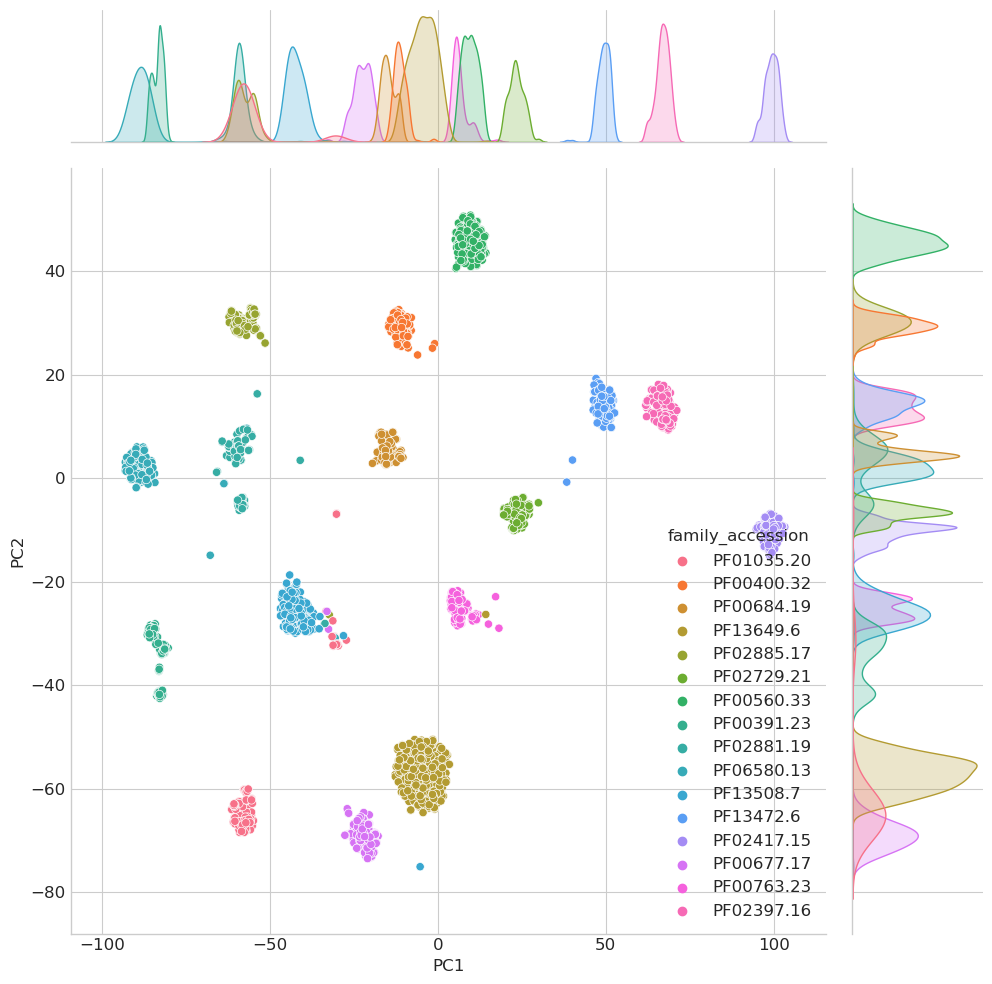

In [100]:
visualize_seq_embeddings(transformer_model, num_most_frequent_labels=16)

The cluster are not as good as before, maybe with more data will could have similar performance (normal for a Transformer model)

#### ProtBert

In [128]:
import gc
gc.collect()

89086

In [68]:
def tokenize_sequences(model, sequences):
    # Tokenizing sequences
    encoded_inputs = model.tokenizer(sequences, padding='max_length', truncation=True, max_length=model.max_length, return_tensors="tf")
    return encoded_inputs['input_ids'], encoded_inputs['attention_mask']

In [137]:
# def create_tokenized_set(protbert, sequences, labels, batch_size):
#    input_ids, attention_masks = tokenize_sequences(protbert, sequences)
#    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks), labels)
#    return dataset.shuffle(len(sequences)).batch(batch_size)

In [1]:
# train_protbert_tok = create_tokenized_set(protbert, x_train_protbert, y_train, batch_size)
# dev_protbert_tok = create_tokenized_set(protbert, x_dev_protbert, y_dev, batch_size)
# test_protbert_tok = create_tokenized_set(protbert, x_test_protbert, y_test, batch_size)

In [69]:
protbert = ProtBERTClassifier(num_labels, device='GPU:0', quantize=True, max_length=max_seq_len)
# protbert.build(input_shape=(batch_size, max_seq_len))
protbert(tokenize_sequences(protbert, x_train_protbert[0]))
protbert.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)
protbert.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "prot_bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_for_sequence_classi  multiple                 420062336 
 fication (TFBertForSequence                                     
 Classification)                                                 
                                                                 
 dropout_92 (Dropout)        multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  16512     
                                                                 
 dropout_93 (Dropout)        multiple                  0         
                                                                 
 dense_1 (Dense)             multiple         

In [70]:
max_epochs = 5

In [ ]:
history_protbert = protbert.fit(
    tokenize_sequences(protbert,x_train_protbert), 
    y_train,
    epochs=max_epochs, 
    validation_data=(tokenize_sequences(protbert,x_dev_protbert), y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

The training was too long i decide to stop it (1 hour 30 for 1 epoch)

In [ ]:
plot_history(history_protbert)

In [ ]:
protbert.evaluate(tokenize_sequences(protbert,x_test_protbert), y_test, batch_size=batch_size, verbose=1)

In [ ]:
# visualize_seq_embeddings(protbert, num_most_frequent_labels=16, to_tokenize=True)

## Result analysis

Results Overview
----------------

Commencing with the **Simple Baseline** model, it yielded an impressive accuracy of **99.69%** on the test set. This achievement, especially given the model's inherent simplicity, underscores its effective generalization. Visualization of sequence embeddings manifests clear demarcations between sequences of varied labels, with distinct and well-separated clusters for each label. This validates the adeptness of the amino acid embedding layer, buttressing the hypothesis that adept amino acid and sequence embeddings are pivotal for our classification task.

Exploring other architectures, the other model exhibited almost analogous results. 

Conclusively, our study signals that profound amino acid embeddings are paramount for high-accuracy protein sequence classification. However, this exploration, being limited to a single dataset and set of conditions, necessitates broader investigations across diverse datasets and configurations for more holistic inferences. Though our results are enlightening, due to inherent constraints, they may need further validation for robust reproducibility. Metrics selection, the extent of classification labels, and multiple experimental repetitions are also pivotal considerations for future endeavors.

### References (code)

Some ideas taken from : 

* Notebook : https://www.kaggle.com/code/gboduljak/pfam-embedding-is-all-you-need
* Notebook : https://www.kaggle.com/code/nistugua/pfam-analysis-classification
* Website : https://towardsdatascience.com/protein-sequence-classification-99c80d0ad2df